In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import stats

In [ ]:
# Pre-Processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings

# Игнорируем предупреждения, связанные с matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Постановка задачи
За прошедшие годы финансовая компания собрала основные банковские реквизиты и много информации, связанной с кредитами. Руководство хочет создать интеллектуальную систему для разделения людей по категориям кредитоспособности, чтобы сократить объем ручного труда.

**Задача:** Учитывая кредитную информацию человека, создайте модель машинного обучения, которая сможет классифицировать кредитный рейтинг.

In [81]:
data = pd.read_csv('train.csv', header=0,  engine='python')
data.shape

(100000, 28)

In [5]:
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## Описание признаков

|Номер признака | Название признака | Вид признака | Описание признака |
|:-------------:|:-----------------:|:------------:|:------------------|
| 1 | ID | Уникальное числовое значение | Уникальный идентификационный номер записи |
| 2 | Customer_ID | Уникальное числовое значение | Уникальный идентификационный номер человека (клиента) |
| 3 | Month | Категориальный | Месяц, в который была сделана запись |
| 4 | Name | Текстовый | Имя и фамилия клиента |
| 5 | Age | Количественный | Возраст клиента |
| 6 | SSN | Уникальное числовое значение | Уникальный девятизначный номер социального страхования |
| 7 | Occupation | Категориальный | Профессия клиента |
| 8 | Annual_Income | Количественный | Годовой доход клиента |
| 9 | Monthly_Inhand_Salary | Количественный | Месячный базовый оклад клиента |
| 10 | Num_Bank_Accounts | Количественный | Количество банковских счетов клиента |
| 11 | Num_Credit_Card | Количественный | Количество кредитных карт у клиента |
| 12 | Interest_Rate | Количественный | Процентная ставка по кредитной карточке клиента |
| 13 | Num_of_Loan | Количественный | Количество кредитов, взятых в банке клиентом |
| 14 | Type_of_Loan | Категориальный | Виды кредитов, взятых в банке клиентом |
| 15 | Delay_from_due_date | Количественный | Среднее количество дней, на которое клиент просрочивает платёж |
| 16 | Num_of_Delayed_Payment | Количественный | Среднее количество просроченных клиентом платежей |
| 17 | Changed_Credit_Limit | Количественный | Изменение в кредитном лимите |
| 18 | Num_Credit_Inquiries | Количественный | Количество заявок на кредиты |
| 19 | Credit_Mix | Категориальный | Оценка разнообразия взятых видов кредитов |
| 20 | Outstanding_Debt | Количественный | Остаток долга, который клиенту надо оплатить (в USD) |
| 21 | Credit_Utilization_Ratio | Количественный | Используемая клиентом доля кредитного лимита |
| 22 | Credit_History_Age | Количественный | Описывает возраст кредитной истории клиента |
| 23 | Payment_of_Min_Amount | Категориальный | Отображает была ли оплачена клиентом только минимальная сумма по кредиту |
| 24 | Total_EMI_per_month | Количественный | Сумма фиксированных месячных платежей по кредитам, совершаемых клиентом (в USD) |
| 25 | Amount_invested_monthly | Количественный | Сумма, которую ежемесячно  |
| 26 | Payment_Behaviour | Категориальный | Поведение клиента (трата/оплата) |
| 27 | Monthly_Balance | Количественный | Месячный баланс (в USD) |
| | Credit_Score | | Класс, описывающий кредитоспособность |

In [82]:
categorial_features = ['Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

numeric_features_with_type = [('Age', int), ('Annual_Income', float), ('Monthly_Inhand_Salary', float), ('Num_Bank_Accounts', int), 
                    ('Num_Credit_Card', int), ('Interest_Rate', int), ('Num_of_Loan', int), ('Delay_from_due_date', int), 
                    ('Num_of_Delayed_Payment', int), ('Changed_Credit_Limit', float), ('Num_Credit_Inquiries', int), 
                    ('Outstanding_Debt', float), ('Credit_Utilization_Ratio', float), ('Credit_History_Age', int), 
                    ('Total_EMI_per_month', float), ('Amount_invested_monthly', float), ('Monthly_Balance', float)]

numeric_features = [x[0] for x in numeric_features_with_type]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

# Анализ и обработка признаков

## Обработка категориальных признаков

In [122]:
def get_value_count(df: pd.Series, feature: str):
    '''
    Функция вычисляет количество категорий и 
    соответствующие им проценты для указанного признака, 
    записывая в отдельный Dataframe

    Return: Dataframe (категория | количество значений | процент)
    '''
    vc = df[feature].value_counts()
    vc_norm = df[feature].value_counts(normalize=True)
    
    vc = vc.rename_axis(feature).reset_index(name='counts')
    vc_norm = vc_norm.rename_axis(feature).reset_index(name='percent')
    vc_norm['percent'] = (vc_norm['percent'] * 100).map('{:.2f}%'.format)
    
    df_result = pd.concat([vc[feature], vc['counts'], vc_norm['percent']], axis=1)
    
    return df_result

In [123]:
def plottingCountplotByClass(df: pd.Series, feature: str):
    '''
    Функция строит столбчатую диаграмму, показывающую количество наблюдений
    в каждом категориальном интервале по классам Credit Score
    '''
    plt.figure(figsize=(25, 8))

    ax = sns.countplot(x=feature, hue='Credit_Score', data=df, palette='Set3')

    plt.title(f'{feature} by Credit Score')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [124]:
# Проверим уникальные значения по каждому признаку, чтобы выявить аномальные значения
for col in categorial_features:
    print(col, data[col].unique())

Month ['May' 'April' 'June' 'January' 'March' 'February' 'July' 'August']
Occupation ['Doctor' 'Lawyer' 'Journalist' 'Entrepreneur' 'Musician' 'Teacher'
 'Architect' 'Manager' '_______' 'Engineer' 'Writer' 'Developer'
 'Media_Manager' 'Mechanic' 'Accountant' 'Scientist']
Type_of_Loan ['Not Specified, Debt Consolidation Loan, and Mortgage Loan'
 'Personal Loan, Personal Loan, Home Equity Loan, and Mortgage Loan'
 'Auto Loan, Personal Loan, Debt Consolidation Loan, and Home Equity Loan'
 ...
 'Auto Loan, Auto Loan, Debt Consolidation Loan, Credit-Builder Loan, and Mortgage Loan'
 'Student Loan, Debt Consolidation Loan, Auto Loan, Auto Loan, Debt Consolidation Loan, Not Specified, and Debt Consolidation Loan'
 'Payday Loan, Home Equity Loan, Auto Loan, and Not Specified']
Credit_Mix ['Good' '_' 'Standard' 'Bad']
Payment_of_Min_Amount ['No' 'NM' 'Yes']
Payment_Behaviour ['Low_spent_Medium_value_payments' 'High_spent_Large_value_payments'
 'High_spent_Medium_value_payments' 'Low_spent_Large

### Occupation

In [ ]:
data['Occupation'].replace('_______', np.nan, inplace=True)
data['Occupation'] = data.groupby('Customer_ID')['Occupation'].transform(lambda x: x.mode()[0])

In [ ]:
# Кодирование признака Occupation
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[['Occupation']])

one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['Occupation']))

data = pd.concat([data.drop('Occupation', axis=1), one_hot_df], axis=1)

### Type_of_Loan

In [126]:
data['Type_of_Loan'] = data['Type_of_Loan'].str.replace('and ','')
unique_loan = list(map(lambda x: str(x), data['Type_of_Loan'].unique()))
unique_loan = ','.join(unique_loan).split(',')
unique_loan = set(map(lambda x: x.lstrip(' '), set(unique_loan)))
unique_loan

{'Auto Loan',
 'Credit-Builder Loan',
 'Debt Consolidation Loan',
 'Home Equity Loan',
 'Mortgage Loan',
 'Not Specified',
 'Payday Loan',
 'Personal Loan',
 'Student Loan',
 'nan'}

In [127]:
unique_loan.discard('nan')
unique_loan.discard('Not Specified')

In [128]:
for type in unique_loan:
    data.insert(loc = data.shape[1]-1, column = type, value = [0] * data.shape[0])
    data[type] = data[type].astype(int)

In [129]:
for info, row in zip(list(list(data['Type_of_Loan'])), range(data.shape[0])):
    info = str(info)
    for type in info.split(', '):
        if type.lstrip(' ') in unique_loan:
            data.loc[row, type.lstrip(' ')] = 1

data = data.drop('Type_of_Loan', axis = 1)

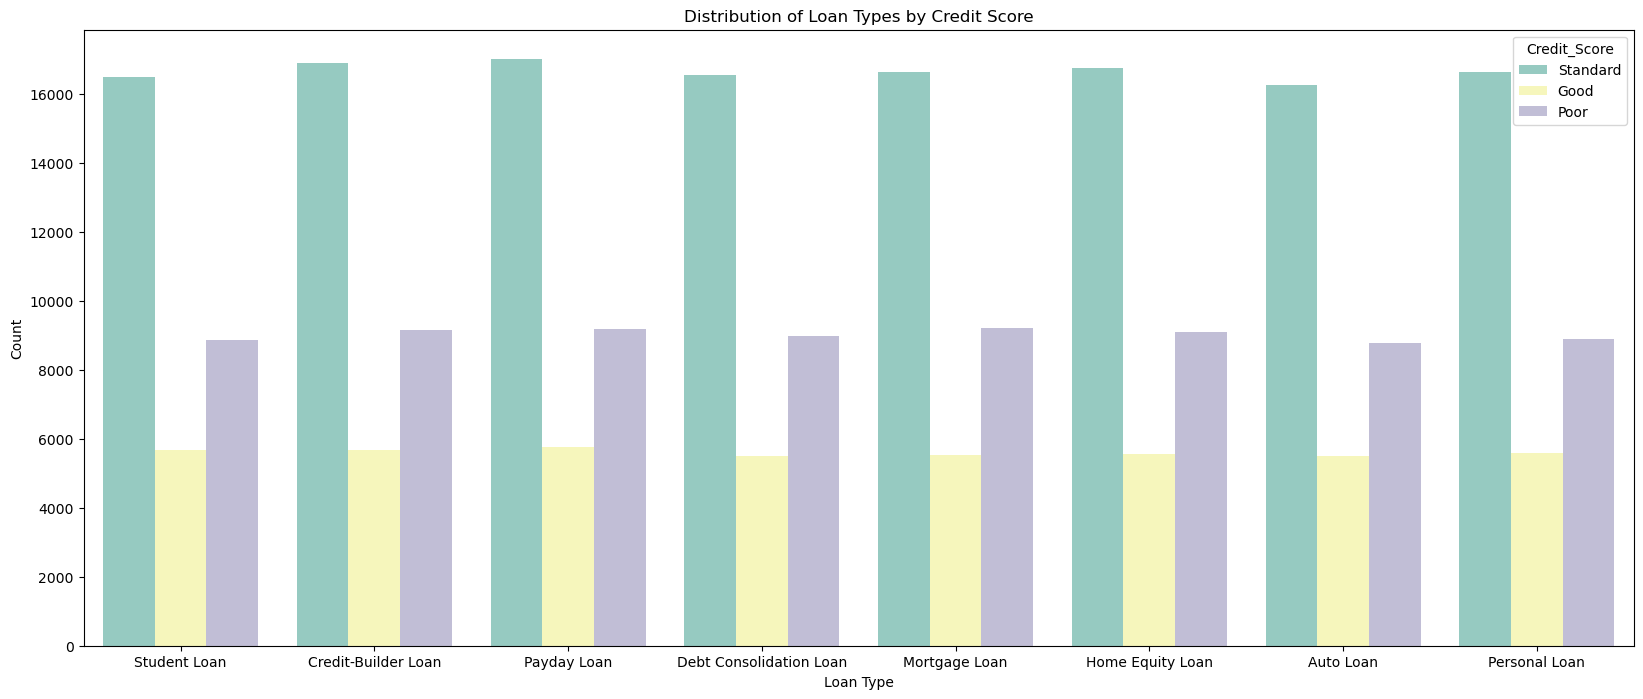

In [130]:
df_melted = data.melt(id_vars='Credit_Score', value_vars=unique_loan, 
                       var_name='Loan Type', value_name='Has Loan')

plt.figure(figsize=(20,8))
sns.countplot(x='Loan Type', hue='Credit_Score', data=df_melted[df_melted['Has Loan'] == 1], palette='Set3')

plt.title('Distribution of Loan Types by Credit Score')
plt.xlabel('Loan Type')
plt.ylabel('Count')

plt.show()

### Credit_Mix

In [131]:
get_value_count(data, 'Credit_Mix')

,Credit_Mix,counts,percent
0,Standard,36479,36.48%
1,Good,24337,24.34%
2,_,20195,20.20%
3,Bad,18989,18.99%


In [132]:
data['Credit_Mix'].replace('_', 'Unknown', inplace=True)

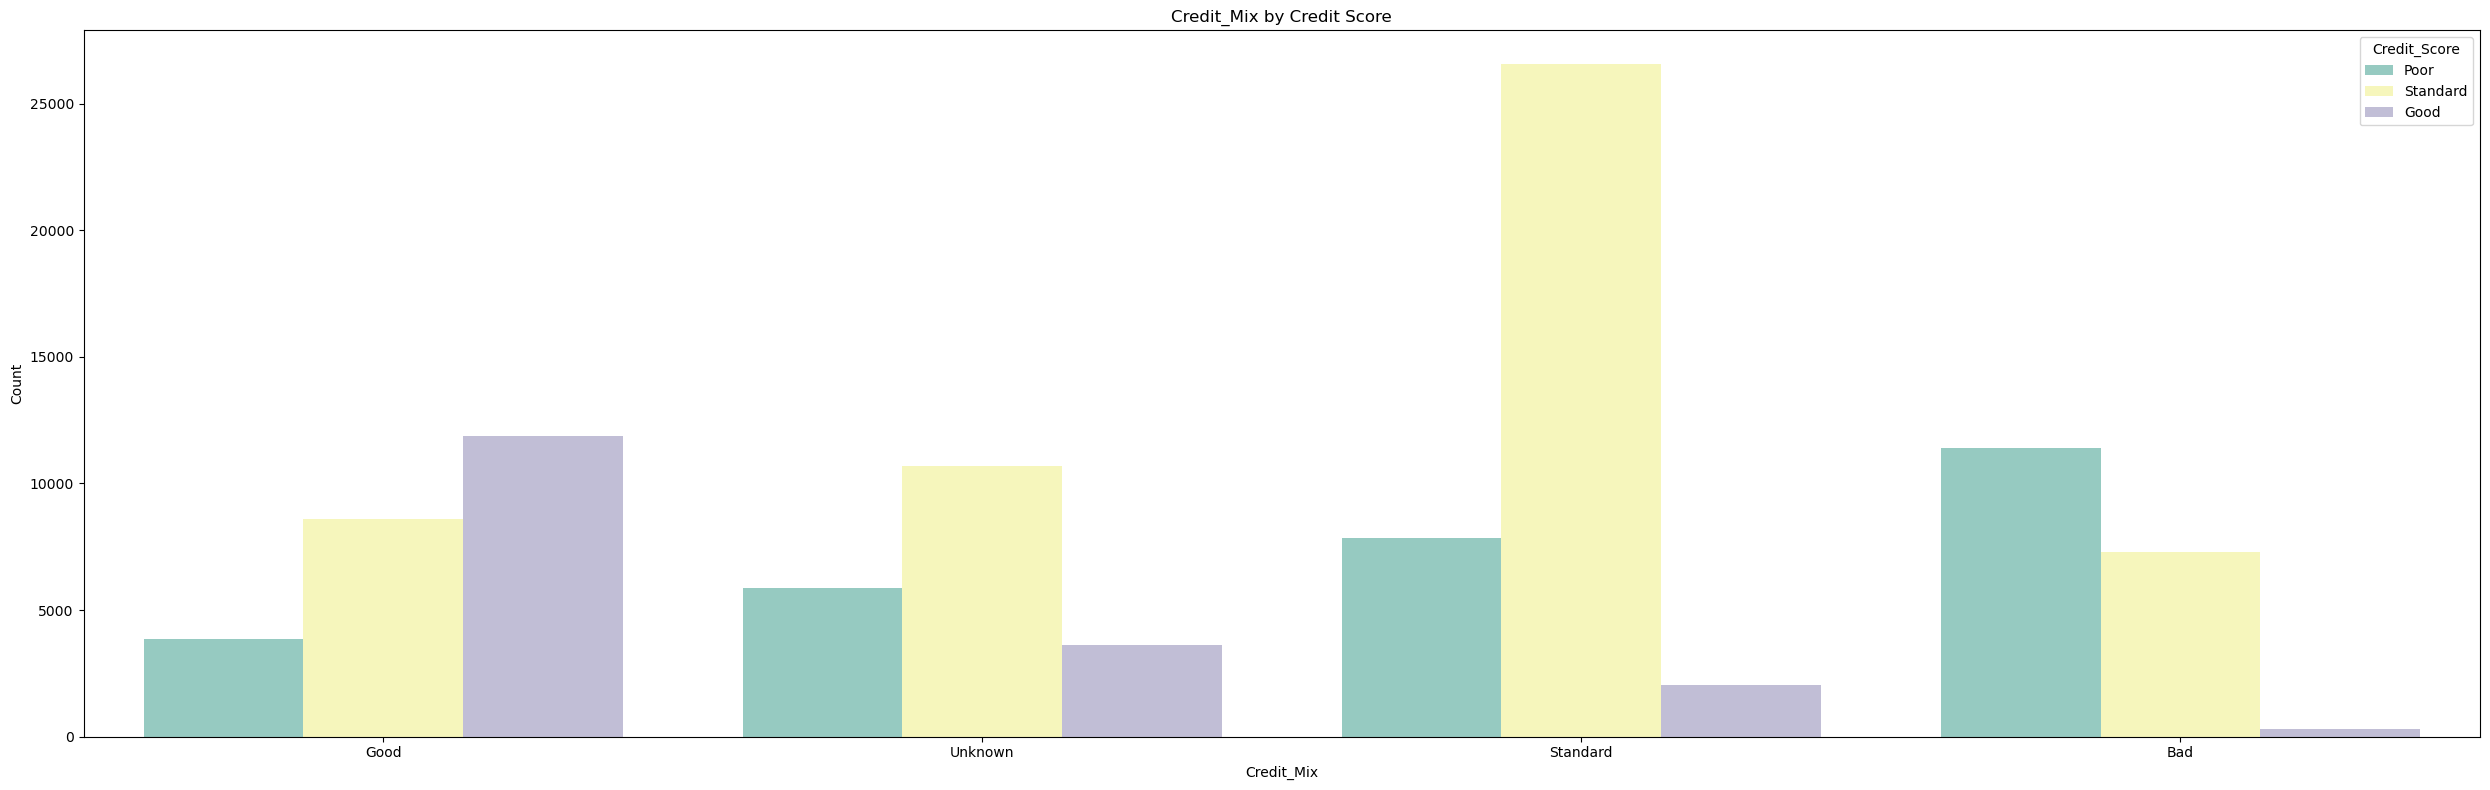

In [133]:
plottingCountplotByClass(data, 'Credit_Mix')

In [134]:
data['Credit_Mix'].replace({"Bad": 0, "Standard": 1, "Good": 2, "Unknown": 3}, inplace=True)
data['Credit_Mix'] = data['Credit_Mix'].astype(int)

### Payment_of_Min_Amount

In [135]:
get_value_count(data, 'Payment_of_Min_Amount')

,Payment_of_Min_Amount,counts,percent
0,Yes,52326,52.33%
1,No,35667,35.67%
2,NM,12007,12.01%


In [136]:
data['Payment_of_Min_Amount'].replace({"No": 0, "Yes": 1, "NM": np.nan}, inplace=True)

In [138]:
data['Payment_of_Min_Amount'] = data['Payment_of_Min_Amount'].astype('Int64')

### Payment_Behaviour

In [139]:
get_value_count(data, 'Payment_Behaviour')

,Payment_Behaviour,counts,percent
0,Low_spent_Small_value_payments,25513,25.51%
1,High_spent_Medium_value_payments,17540,17.54%
2,Low_spent_Medium_value_payments,13861,13.86%
3,High_spent_Large_value_payments,13721,13.72%
4,High_spent_Small_value_payments,11340,11.34%
5,Low_spent_Large_value_payments,10425,10.42%
6,!@9#%8,7600,7.60%


In [140]:
data['Payment_Behaviour'].replace('!@9#%8', np.nan, inplace=True)

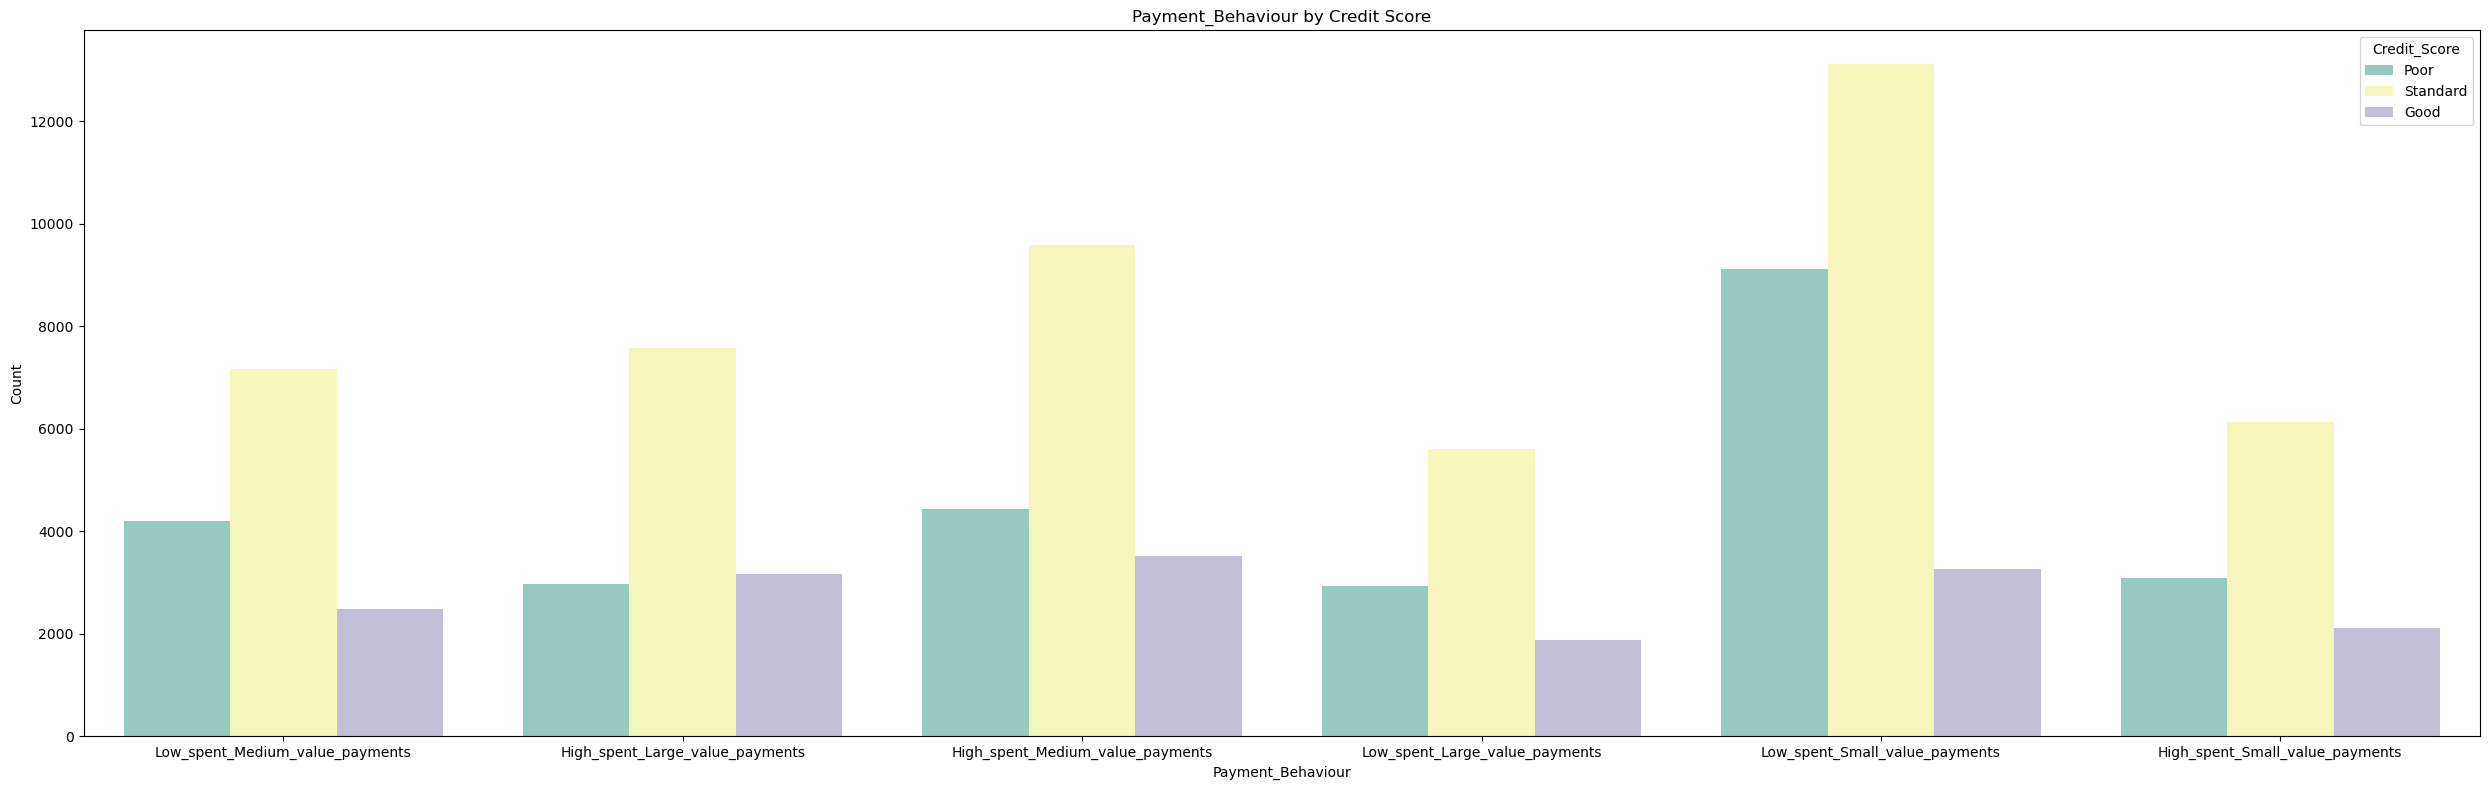

In [141]:
plottingCountplotByClass(data, 'Payment_Behaviour')

Можно разделить этот признак на два:
- Amount_Spent
- - 0 - Low_spent
- - 1 - Hight_spent
- Payment_Value
- - 0 - Small_value_payments
- - 1 - Medium_value_payments
- - 2 - Large_value_payments

In [142]:
data.insert(loc = data.shape[1]-1, column = 'Amount_Spent', value = [np.nan] * data.shape[0])
data.insert(loc = data.shape[1]-1, column = 'Payment_Value', value = [np.nan] * data.shape[0])

In [143]:
for i in range(0, data['Payment_Behaviour'].size):
    match data.at[i, 'Payment_Behaviour']:
        case 'Low_spent_Small_value_payments':
            data.at[i, 'Amount_Spent'] = 0
            data.at[i, 'Payment_Value'] = 0
        case 'High_spent_Medium_value_payments':
            data.at[i, 'Amount_Spent'] = 1
            data.at[i, 'Payment_Value'] = 1
        case 'Low_spent_Medium_value_payments':
            data.at[i, 'Amount_Spent'] = 0
            data.at[i, 'Payment_Value'] = 1
        case 'High_spent_Large_value_payments':
            data.at[i, 'Amount_Spent'] = 1
            data.at[i, 'Payment_Value'] = 2
        case 'High_spent_Small_value_payments':
            data.at[i, 'Amount_Spent'] = 1
            data.at[i, 'Payment_Value'] = 0
        case 'Low_spent_Large_value_payments':
            data.at[i, 'Amount_Spent'] = 0
            data.at[i, 'Payment_Value'] = 2

data = data.drop('Payment_Behaviour', axis = 1)

In [144]:
data['Amount_Spent'] = data['Amount_Spent'].astype('Int64')
data['Payment_Value'] = data['Payment_Value'].astype('Int64')

## Обработка количественных признаков

In [145]:
NAN_INDICATING_CONSTANT = np.NaN

In [ ]:
def toNumeric(df: pd.Series, feature: str, type: type):
    '''
    Функция, преобразующая признаки с загрязненными данными в числовые (int/float)
    
    Return: Dataframe с измененным признаком
    '''
    result_df = df.copy()

    # Функция для обработки каждой строки
    def convert_value(value):
        try:
            return type(value)
        except ValueError:
            if type == int:
                number_list = re.findall(r'\d+', str(value))
            else:
                number_list = re.findall(r'\d+\.\d+', str(value))
            
            temp = "".join(number_list)
            return type(temp) if temp else NAN_INDICATING_CONSTANT
    
    # Применяем функцию к каждому элементу в столбце
    return result_df[feature].apply(convert_value)


    # for i in range(0, result_df[feature].size):
    #     try:
    #         result_df.at[i, feature] = type(result_df.at[i, feature])
    #     except ValueError:
    #         if (type == int):
    #             number_list = re.findall(r'\d+', str(result_df.at[i, feature]))
    #         else:
    #             number_list = re.findall(r'\d+\.\d+', str(result_df.at[i, feature]))
            
    #         temp = ""
    #         for item in number_list:
    #             temp += item
    #         if (temp):
    #             resulting_value = type(temp)
    #         else:
    #             resulting_value = NAN_INDICATING_CONSTANT
            
    #         result_df.at[i, feature] = resulting_value
    # return result_df[feature]

In [13]:
def CorrectCreditHistoryAge(age):
    '''
    Функция преобразует строку возраста кредитной истории (в формате «X Year and Y Month») 
    в общее количество месяцев
    '''
    try:
        years = int(re.findall(r'\d+', age.split("and")[0])[0])
        months = int(re.findall(r'\d+', age.split("and")[1])[0])
        return int(years * 12 + months)
    
    except (IndexError, ValueError, AttributeError):
        # Возвращает NaN, если входная строка имеет неправильный формат или возникла ошибка.
        return NAN_INDICATING_CONSTANT

In [83]:
data['Credit_History_Age'] = data['Credit_History_Age'].apply(CorrectCreditHistoryAge)
data['Credit_History_Age'] = data['Credit_History_Age'].astype('Int64')

In [84]:
for feature, type in numeric_features_with_type:
    if data[feature].dtype == 'object':
        data[feature] = toNumeric(data, feature = feature, type = type)

        if type == int:
            data[feature] = data[feature].astype('Int64')
            
        else: 
            data[feature] = data[feature].astype('float64')

### Описательные характеристики количественных признаков (предварительный анализ)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,75000.0,109.697187,682.750107,-500.0,24.0,33.0,42.0,8698.0
Annual_Income,75000.0,175618.800153,1426534.104467,7005.93,19399.32,37424.16,72618.32,24198062.0
Monthly_Inhand_Salary,63754.0,4185.292313,3181.357018,303.645417,1623.1225,3081.9025,5943.868338,15204.633333
Num_Bank_Accounts,75000.0,17.030933,116.959483,-1.0,4.0,6.0,7.0,1798.0
Num_Credit_Card,75000.0,22.30288,128.822061,0.0,4.0,5.0,7.0,1499.0
Interest_Rate,75000.0,71.66768,464.308772,1.0,8.0,13.0,20.0,5797.0
Num_of_Loan,75000.0,3.21756,64.403711,-100.0,1.0,3.0,5.0,1496.0
Delay_from_due_date,75000.0,21.074,14.838249,-5.0,10.0,18.0,28.0,67.0
Num_of_Delayed_Payment,69773.0,31.68409,232.487698,-3.0,9.0,14.0,18.0,4397.0
Changed_Credit_Limit,73405.0,10.397659,6.783902,-6.49,5.35,9.41,14.87,36.97


### Анализ и обработка выбросов

In [17]:
def plottingBoxplotByClass(df: pd.Series, features: list):
    '''
    Функция, строящая графики boxplot для числовых признаков по классу Credit_Score
    для выявления и визуализации выбросов
    '''
    num_cols = 4
    num_rows = (len(features) + num_cols - 1) // num_cols

    plt.figure(figsize=(20, num_rows * 5))

    for i, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x='Credit_Score', y=feature, data=df, palette='Set3')
        plt.title(f'Boxplot of {feature} by Credit Score', fontsize=13, pad=10)
        plt.xlabel('Credit Score', fontsize=13)
        plt.ylabel(feature, fontsize=13)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

    plt.ylim(df[feature].min() - (df[feature].max() - df[feature].min()) * 0.1,
                df[feature].max() + (df[feature].max() - df[feature].min()) * 0.1)

    plt.subplots_adjust(wspace=0.4, hspace=0.7)

    plt.tight_layout()
    plt.show()

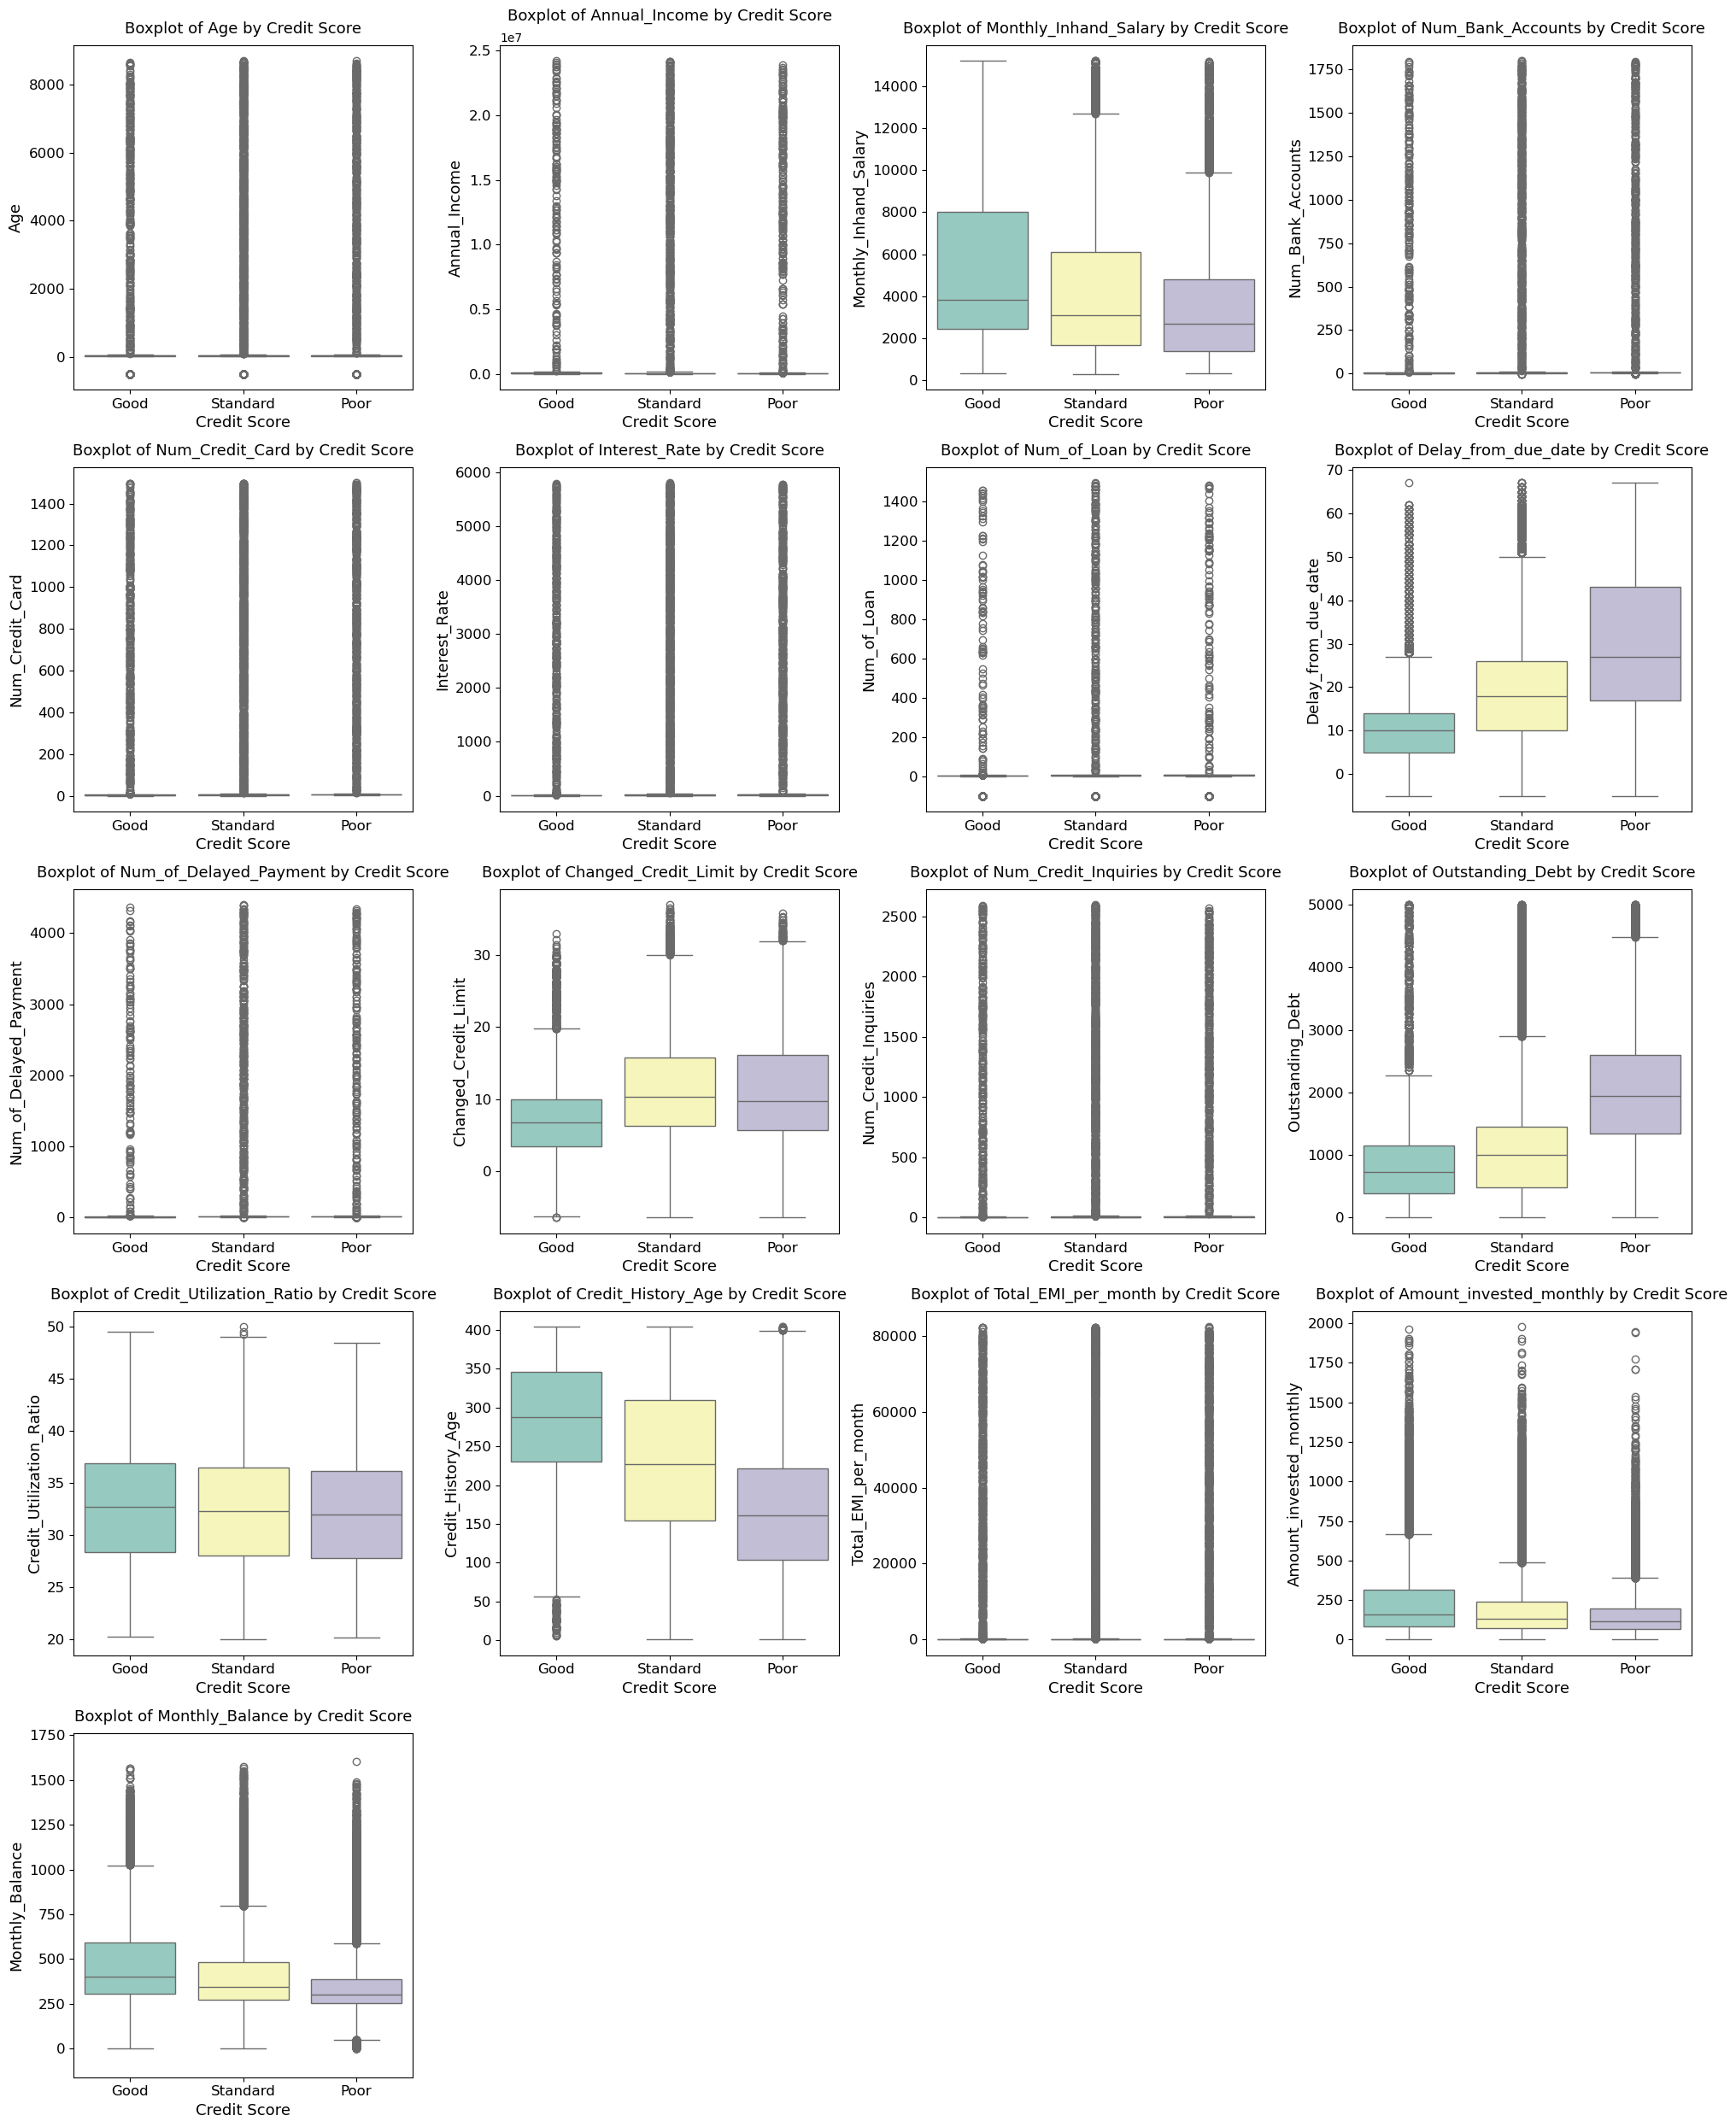

In [85]:
plottingBoxplotByClass(data, numeric_features)

В данных есть огромное количество выбросов. \
Чтобы выявить выбросы, используем метод, основанный на межквартильном расстоянии. \
То есть, будем считать выбросом те значения, которые находятся за пределами отрезка $$[Q_1 - 1.5 * (Q_3 - Q_1), Q_3 + 1.5 * (Q_3 - Q_1)]$$ 

Далее будем работать следующим образом с этими значениями и пропущенными значениями:
- Создадим подмножество с записями о клиенте по Customer_ID, в котором будут только допустимые значения
- Если в этом подмножестве нет записей - то значение будет NaN, будем корректировать его иначе.
- Если значения есть и есть мода, то заменяем на нее.
- Если значения есть и нет моды, то заменяем на медиану по этому признаку по записям клиента.
- Иначе, если ничего из вышеперечисленного, то это значит, что мода нашлась и равна подозрительному значению, следовательно, это, вероятно, не выброс, а просто необычное значение.

In [19]:
def handleOutliersAndMissing(df: pd.Series, feature: str, allow_Negative = False):
    '''
    Функция определяет выбросы с использованием межквартильного расстояния
    и корректирует найденные значения, а также отсутсвующие значения,
    если это возможно, иначе данное значение остается NaN
    
    Return: Dataframe с обработанным столбцом
    '''
    result_df = df.copy()

    quartiles = result_df[feature].quantile([0.25, 0.75]).tolist()
    IQR = quartiles[1] - quartiles[0]

    lower_bound = quartiles[0] - 1.5 * IQR
    if (not allow_Negative) and (lower_bound < 0):
        lower_bound = result_df[result_df[feature] >= 0][feature].min()
    upper_bound = quartiles[1] + 1.5 * IQR

    valid_values_df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    for i in df[(df[feature].isna()) | (df[feature] < lower_bound) | (df[feature] > upper_bound)].index.tolist():

        # Строим подмножество с корректными значениями по клиенту
        client_subset = valid_values_df[valid_values_df['Customer_ID'] == df.at[i, 'Customer_ID']]
        if (not allow_Negative):
            client_subset = client_subset[client_subset[feature] >= 0]
        
        if (not client_subset[feature].size):
            result_df.at[i, feature] = NAN_INDICATING_CONSTANT
        
        client_mode = stats.mode(client_subset[feature])[0]

        if (np.isnan(client_mode)):
            result_df.at[i, feature] = client_subset[feature].median()
        else:
            result_df.at[i, feature] = client_mode

    return result_df[feature]

In [86]:
for feature in numeric_features:
    if feature == 'Changed_Credit_Limit':
        data[feature] = handleOutliersAndMissing(df = data, feature = feature, allow_Negative=True)
    else:
        data[feature] = handleOutliersAndMissing(df = data, feature = feature)

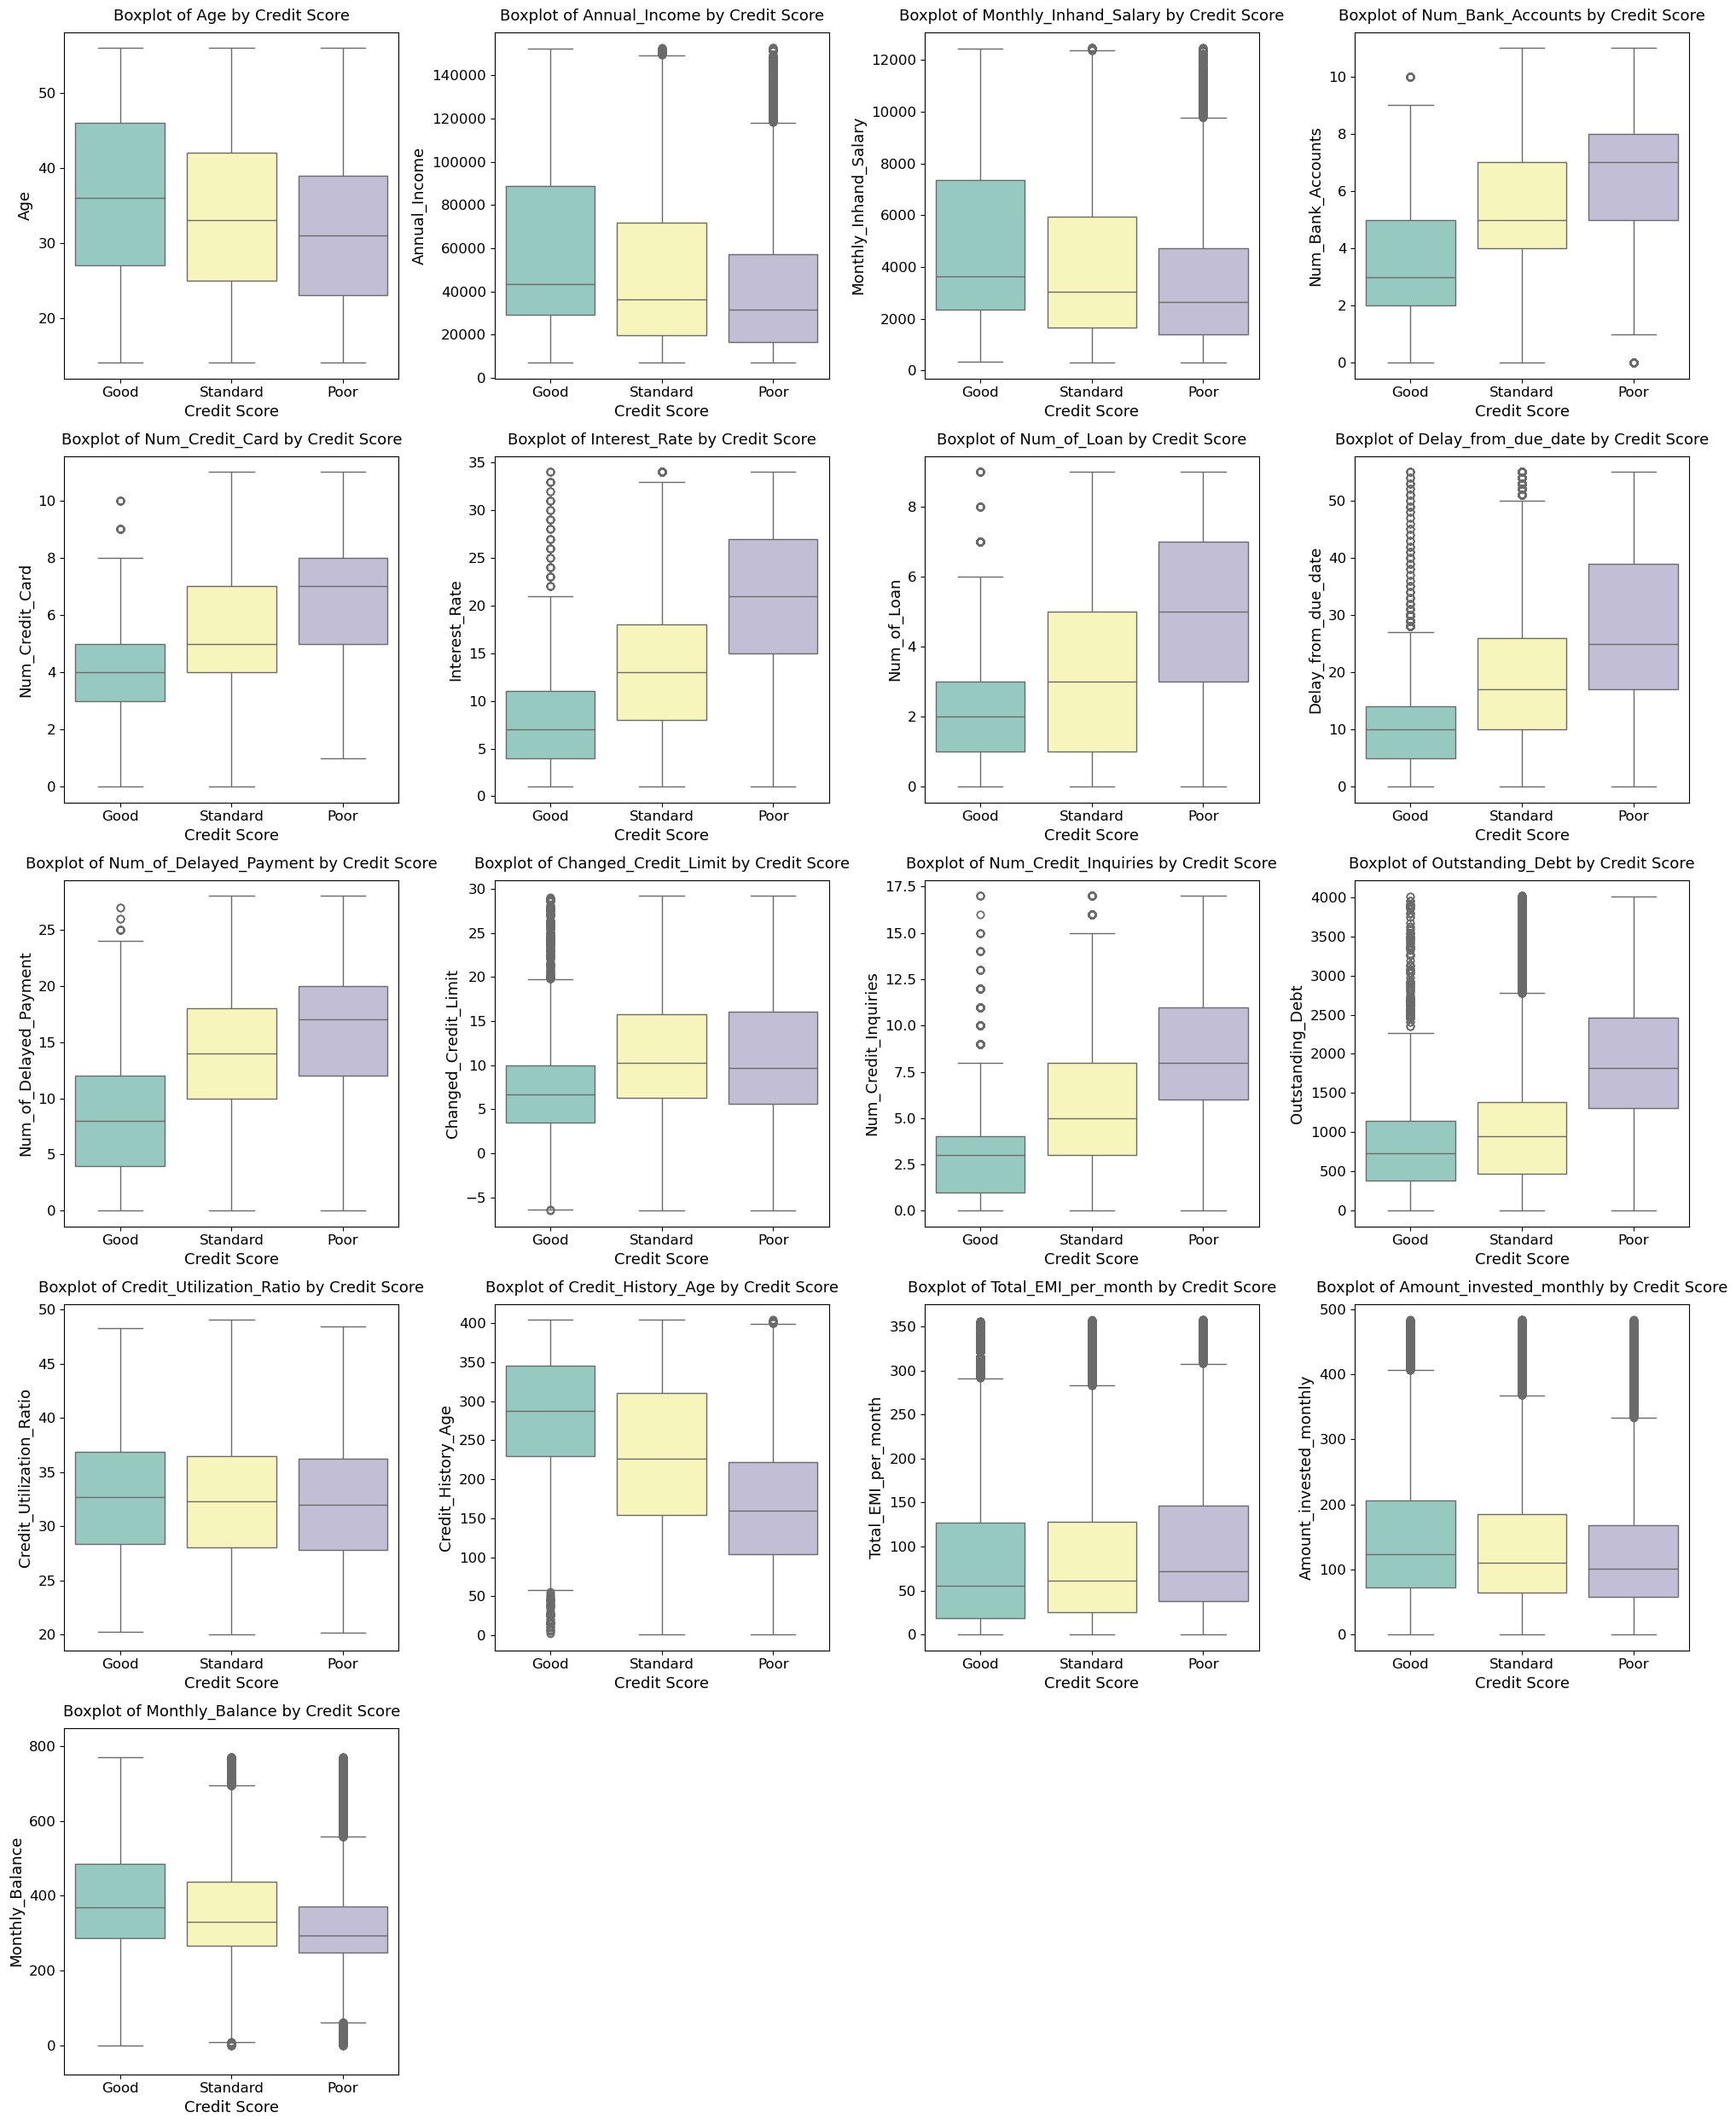

In [87]:
plottingBoxplotByClass(data, numeric_features)

Таким образом, ситуация стала лучше. Выбросы, которые остались за пределами наименьшей/наибольшей границы среди классов по-видимому являются необычными значениями. И поскольку отклонения не очень сильные, то их можно оставить в датасете.

# Разделение выборки на тестовую и обучающую

In [154]:
data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Month'], axis = 1)
data.shape

(100000, 45)

In [155]:
data = data.sample(frac = 1)

In [156]:
X = data.drop(columns ="Credit_Score")
y = data["Credit_Score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
X_train.shape, X_test.shape

((75000, 44), (25000, 44))

In [157]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

In [158]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Обработка пропущенных значений

Пропущенные значения будем восстанавливать с помощью алгоритма KNN. Он работает, находя ближайших соседей для каждой записи с пропущенными значениями и заполняя эти пропуски значениями, основанными на средних (или медианных) значениях соседей.

In [105]:
def kNNImputeFeature(df: pd.Series, feature: str, n_neighbors=5):
    '''
    Функция заменяет пропущенные значения в указанном столбце с помощью алгоритма KNN.

    Возвращает: DataFrame с обработанным столбцом.
    '''
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[[feature]] = imputer.fit_transform(df[[feature]])
    
    return df

In [ ]:
def FindAndCountMissing(df: pd.Series, feаtures: list):
    features_with_missing = []
    count_missing_all = 0

    for feature in feаtures:
        count_missing = df[feature].isna().sum()
        count_missing_all += count_missing

        if count_missing:
            features_with_missing.append(feature)

        print(f'Missing values in {feature}: {count_missing}')

    value_count = df.shape[0]
    missing_percentage = round(count_missing_all / value_count * 100, 2)
    print('--------------------------------------------')
    print(f'Total missing values : count: {count_missing_all} - {missing_percentage}%')

    return features_with_missing

In [160]:
print('Missing values ​​in the TRAIN dataset:\n')
missing_train = FindAndCountMissing(df_train, df_train.keys().tolist())

Missing values ​​in the TRAIN dataset:

Missing values in Age: 0
Missing values in Annual_Income: 1339
Missing values in Monthly_Inhand_Salary: 352
Missing values in Num_Bank_Accounts: 0
Missing values in Num_Credit_Card: 0
Missing values in Interest_Rate: 0
Missing values in Num_of_Loan: 0
Missing values in Delay_from_due_date: 1970
Missing values in Num_of_Delayed_Payment: 0
Missing values in Changed_Credit_Limit: 147
Missing values in Num_Credit_Inquiries: 0
Missing values in Credit_Mix: 0
Missing values in Outstanding_Debt: 3930
Missing values in Credit_Utilization_Ratio: 0
Missing values in Credit_History_Age: 0
Missing values in Payment_of_Min_Amount: 8993
Missing values in Total_EMI_per_month: 1752
Missing values in Amount_invested_monthly: 12
Missing values in Monthly_Balance: 334
Missing values in Occupation_Accountant: 0
Missing values in Occupation_Architect: 0
Missing values in Occupation_Developer: 0
Missing values in Occupation_Doctor: 0
Missing values in Occupation_Engin

In [161]:
print('Missing values ​​in the TEST dataset:\n')
missing_test = FindAndCountMissing(df_test, df_test.keys().tolist())

Missing values ​​in the TEST dataset:

Missing values in Age: 0
Missing values in Annual_Income: 461
Missing values in Monthly_Inhand_Salary: 104
Missing values in Num_Bank_Accounts: 0
Missing values in Num_Credit_Card: 0
Missing values in Interest_Rate: 0
Missing values in Num_of_Loan: 0
Missing values in Delay_from_due_date: 686
Missing values in Num_of_Delayed_Payment: 0
Missing values in Changed_Credit_Limit: 77
Missing values in Num_Credit_Inquiries: 0
Missing values in Credit_Mix: 0
Missing values in Outstanding_Debt: 1342
Missing values in Credit_Utilization_Ratio: 0
Missing values in Credit_History_Age: 0
Missing values in Payment_of_Min_Amount: 3014
Missing values in Total_EMI_per_month: 624
Missing values in Amount_invested_monthly: 4
Missing values in Monthly_Balance: 114
Missing values in Occupation_Accountant: 0
Missing values in Occupation_Architect: 0
Missing values in Occupation_Developer: 0
Missing values in Occupation_Doctor: 0
Missing values in Occupation_Engineer: 0

Однако по предположению данные по признаку 'Monthly_Inhand_Salary' можем восстановить исходя из данных по 'Annual_Income'. И так как по второму так же отсутсвуют значения, то применим KNN сначала к нему.

In [162]:
kNNImputeFeature(df_train, 'Annual_Income')
print(f'Missing values in Annual_Income: {df_train['Annual_Income'].isna().sum()}')

Missing values in Annual_Income: 0


In [163]:
kNNImputeFeature(df_test, 'Annual_Income')
print(f'Missing values in Annual_Income: {df_test['Annual_Income'].isna().sum()}')

Missing values in Annual_Income: 0


In [164]:
df_train['Monthly_Inhand_Salary'].fillna(df_train['Annual_Income'] / 12, inplace=True)
print(f'Missing values in Monthly_Inhand_Salary: {df_train['Monthly_Inhand_Salary'].isna().sum()}')

Missing values in Monthly_Inhand_Salary: 0


In [165]:
df_test['Monthly_Inhand_Salary'].fillna(df_test['Annual_Income'] / 12, inplace=True)
print(f'Missing values in Monthly_Inhand_Salary: {df_test['Monthly_Inhand_Salary'].isna().sum()}')

Missing values in Monthly_Inhand_Salary: 0


In [166]:
missing_train.remove('Monthly_Inhand_Salary')
missing_train.remove('Annual_Income')

missing_test.remove('Monthly_Inhand_Salary')
missing_test.remove('Annual_Income')

In [167]:
for feature in missing_train:
    kNNImputeFeature(df_train, feature)
    print(f'Missing values in {feature}: {df_train[feature].isna().sum()}')

Missing values in Delay_from_due_date: 0
Missing values in Changed_Credit_Limit: 0
Missing values in Outstanding_Debt: 0
Missing values in Payment_of_Min_Amount: 0
Missing values in Total_EMI_per_month: 0
Missing values in Amount_invested_monthly: 0
Missing values in Monthly_Balance: 0
Missing values in Amount_Spent: 0
Missing values in Payment_Value: 0


In [168]:
for feature in missing_test:
    kNNImputeFeature(df_test, feature)
    print(f'Missing values in {feature}: {df_test[feature].isna().sum()}')

Missing values in Delay_from_due_date: 0
Missing values in Changed_Credit_Limit: 0
Missing values in Outstanding_Debt: 0
Missing values in Payment_of_Min_Amount: 0
Missing values in Total_EMI_per_month: 0
Missing values in Amount_invested_monthly: 0
Missing values in Monthly_Balance: 0
Missing values in Amount_Spent: 0
Missing values in Payment_Value: 0


### Описательные характеристики количественных признаков (после обработки)

In [169]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,75000.0,33.295573,10.769431,14.0,24.0,33.0,42.0,56.0
Annual_Income,75000.0,48289.109949,34741.969018,7005.93,19386.02,36984.76,69014.48,152574.76
Monthly_Inhand_Salary,75000.0,3996.843033,2889.4604,303.645417,1618.490208,3046.515,5759.3025,12654.546667
Num_Bank_Accounts,75000.0,5.37128,2.587612,0.0,3.0,5.0,7.0,11.0
Num_Credit_Card,75000.0,5.533587,2.064389,0.0,4.0,5.0,7.0,11.0
Interest_Rate,75000.0,14.5226,8.732691,1.0,7.0,13.0,20.0,34.0
Num_of_Loan,75000.0,3.531227,2.445253,0.0,2.0,3.0,5.0,9.0
Delay_from_due_date,75000.0,19.983774,13.186262,0.0,10.0,18.0,27.0,55.0
Num_of_Delayed_Payment,75000.0,13.325147,6.265927,0.0,9.0,14.0,18.0,28.0
Changed_Credit_Limit,75000.0,10.328696,6.651995,-6.49,5.34,9.41,14.77,29.19


### Удаление некорректных данных

Корректность данных мы можем проверить по допустимой разнице в возврасте клиента и возрасте его кредитной истории. Очевидно второй не должен превышать первый

In [170]:
df_train = df_train.drop(df_train[df_train['Age'] * 12 - df_train['Credit_History_Age'] < 0].index)
df_train.reset_index(inplace=True)
df_train.shape

(66136, 46)

In [171]:
df_test = df_test.drop(df_test[df_test['Age'] * 12 - df_test['Credit_History_Age'] < 0].index)
df_test.reset_index(inplace=True)
df_test.shape

(22057, 46)

### Удаление дупликатов

In [172]:
df_train.drop_duplicates(keep = 'first')
df_train.shape

(66136, 46)

## Визуализация данных

In [173]:
def plottingHistplot(df: pd.Series, features: list):
    '''
    Функция построения гистограмм для числовых признаков,
    визуализирующих распределение данных
    '''
    num_cols = 4
    num_rows = (len(features) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {feature}')
    
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

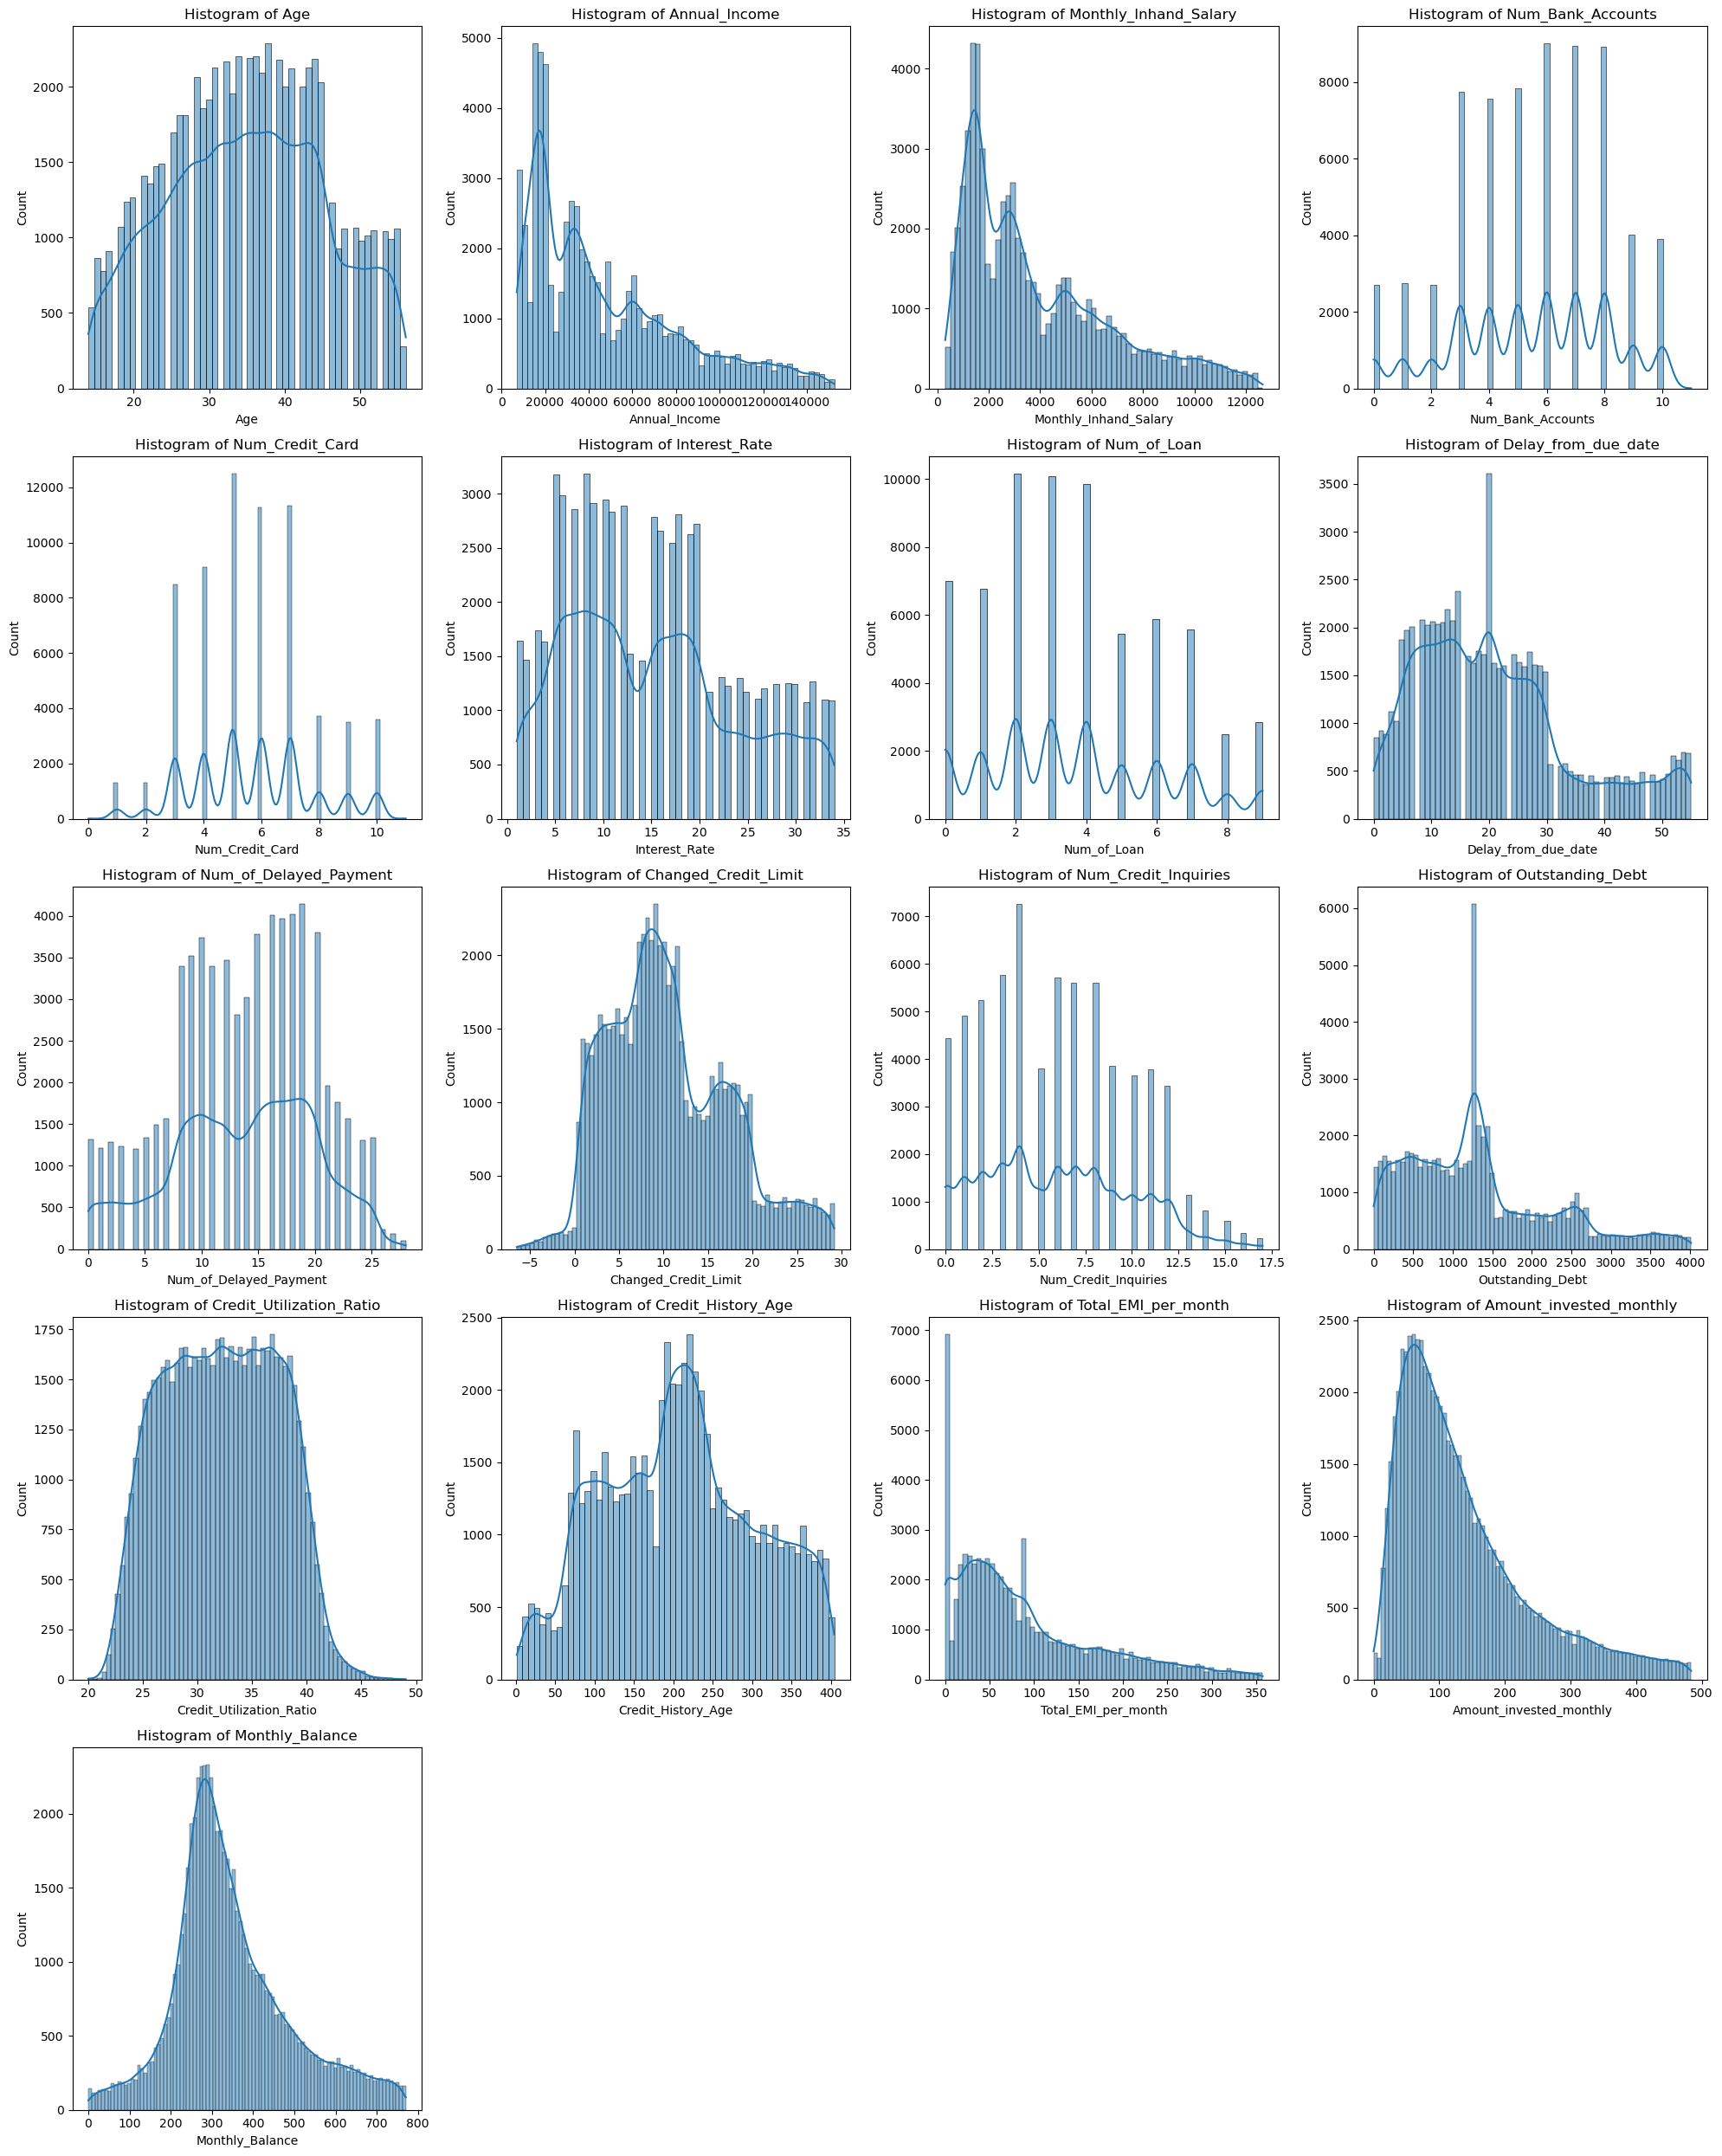

In [174]:
plottingHistplot(df_train, numeric_features)

In [175]:
def plottingBarplotByClasses(df: pd.Series, features: list):
    '''
    Функция построения гистограмм, показывающих среднее значение 
    числового признака по классам Credit Score
    '''
    num_cols = 4
    num_rows = (len(features) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.barplot(x='Credit_Score', y=feature, data=df, ci=None, palette='Set3', ax=ax)

        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', 
                        xytext=(0, 9), textcoords='offset points')

        ax.set_title(f'Average Number of {feature} by Classes')
        ax.set_xlabel(feature)
        ax.set_ylabel(f'Average Number of {feature}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

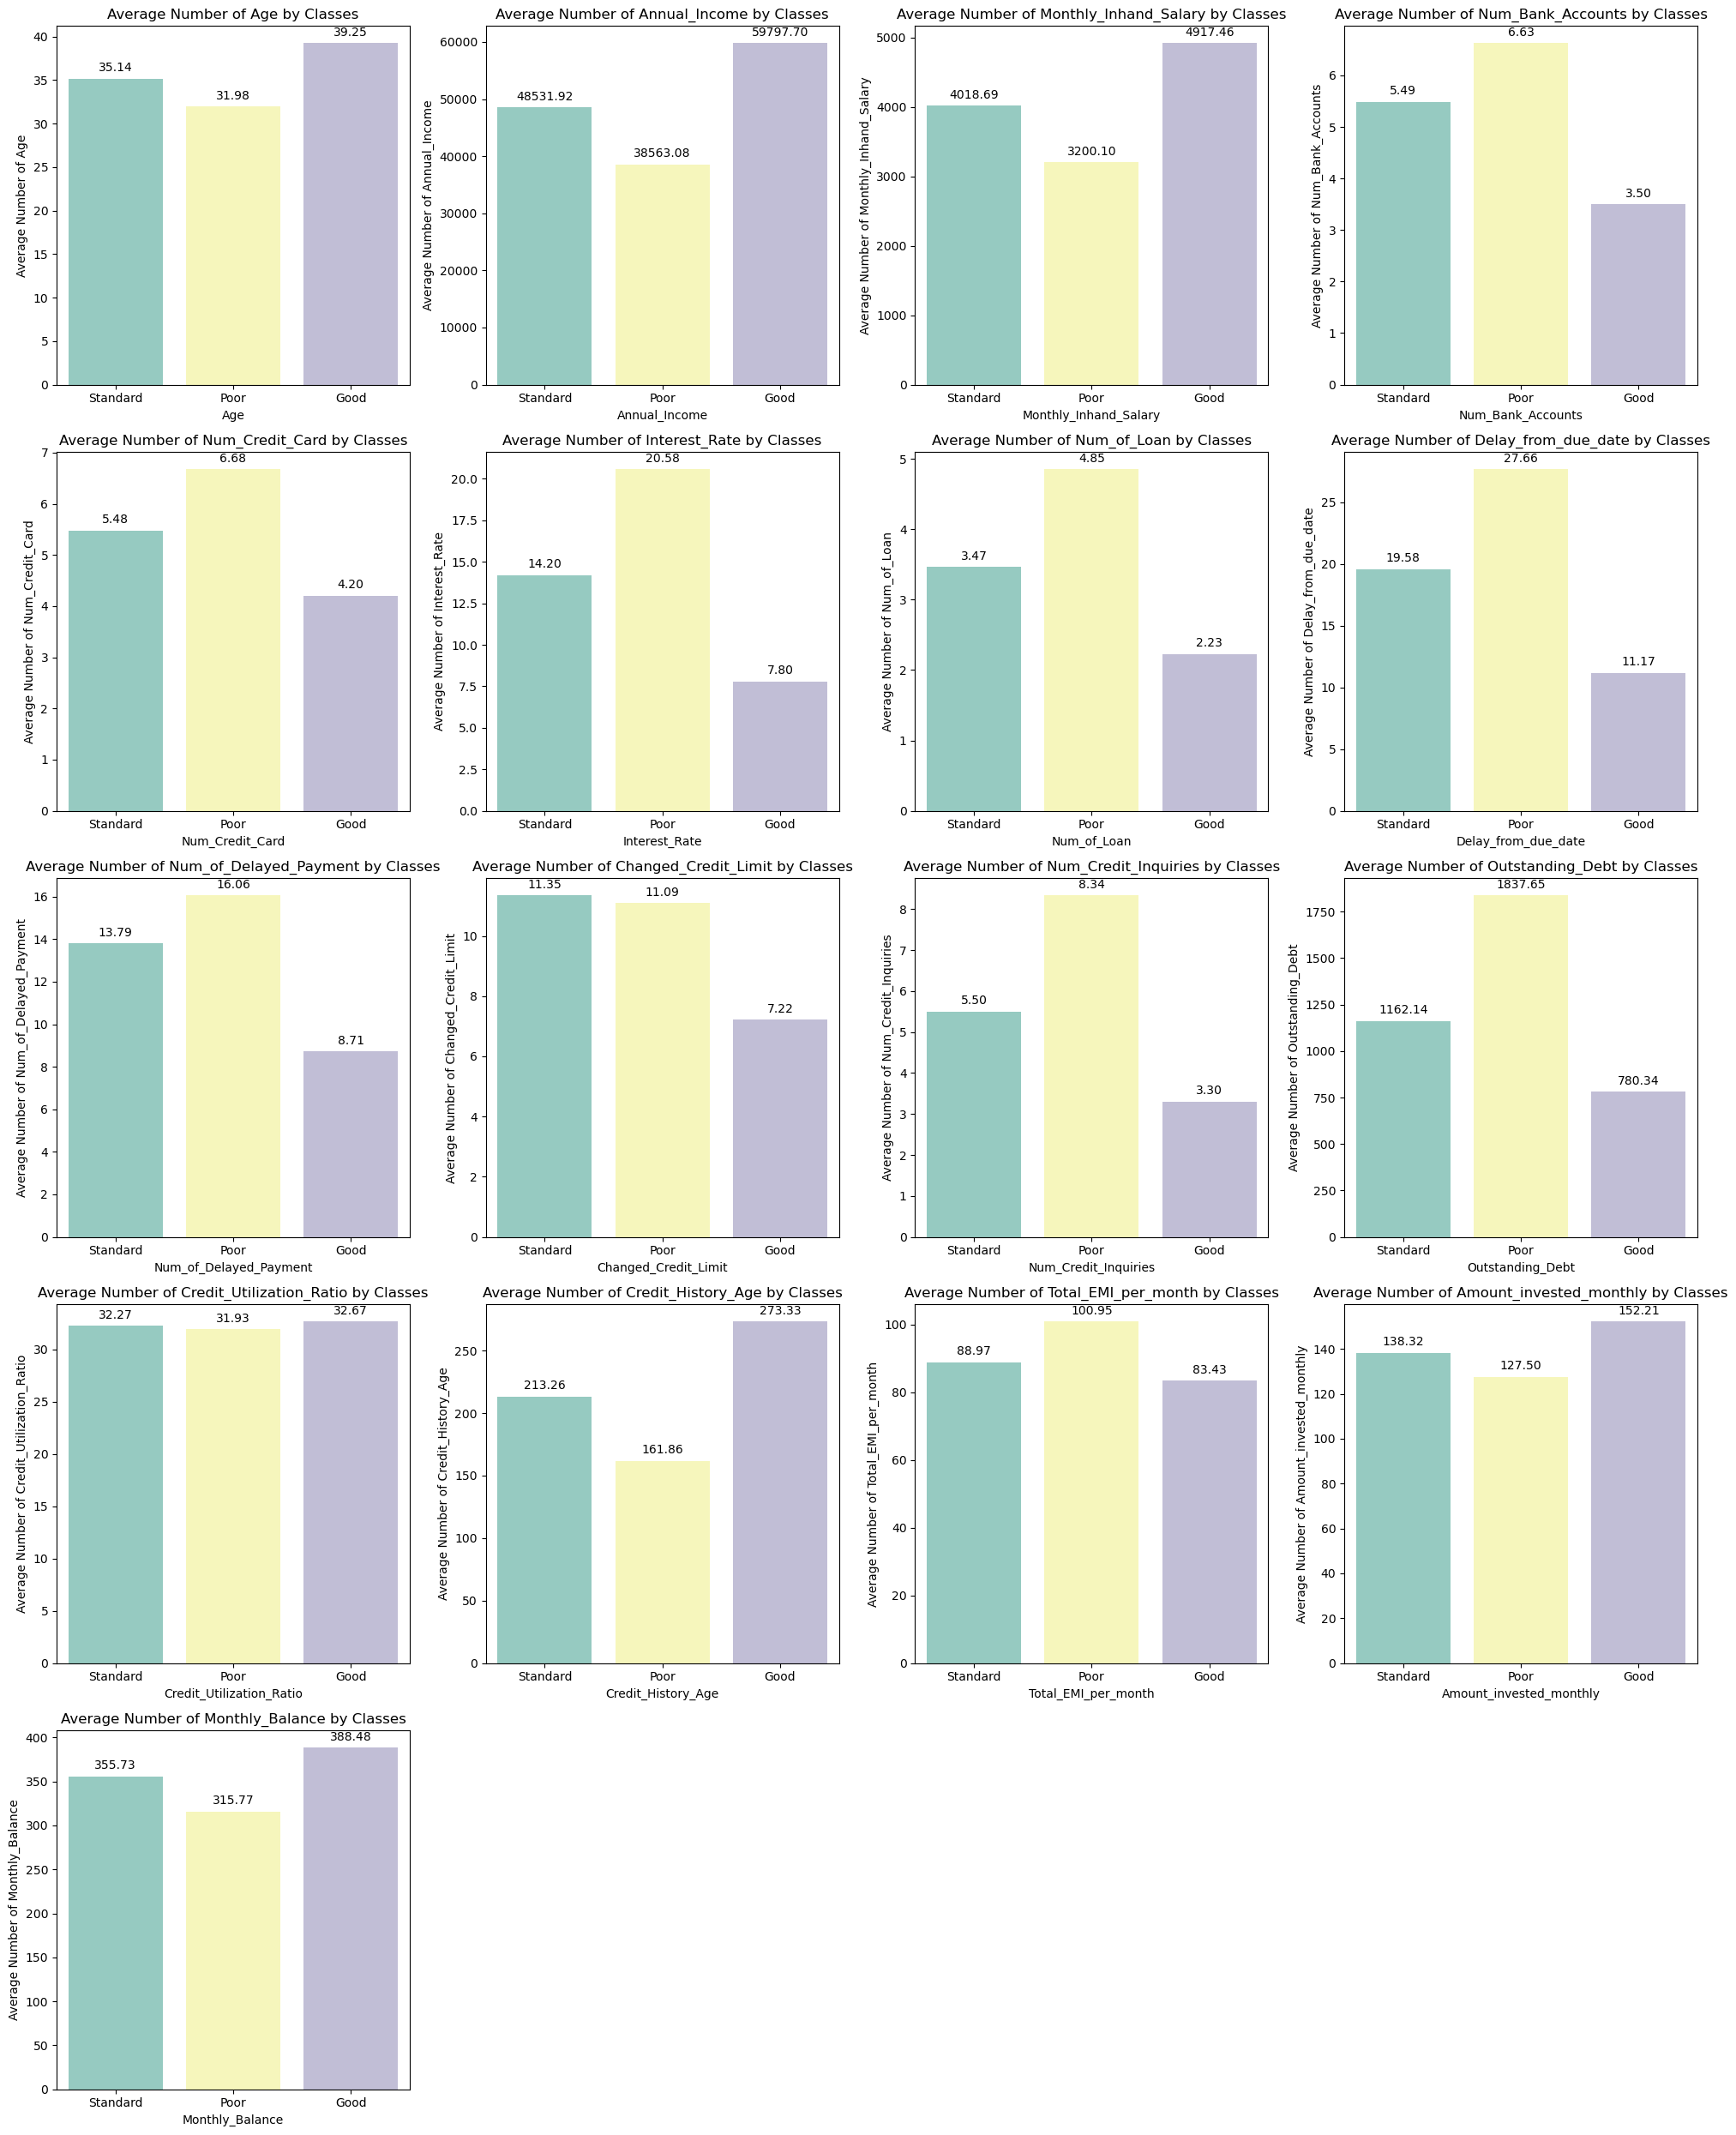

In [177]:
plottingBarplotByClasses(df_train, numeric_features)

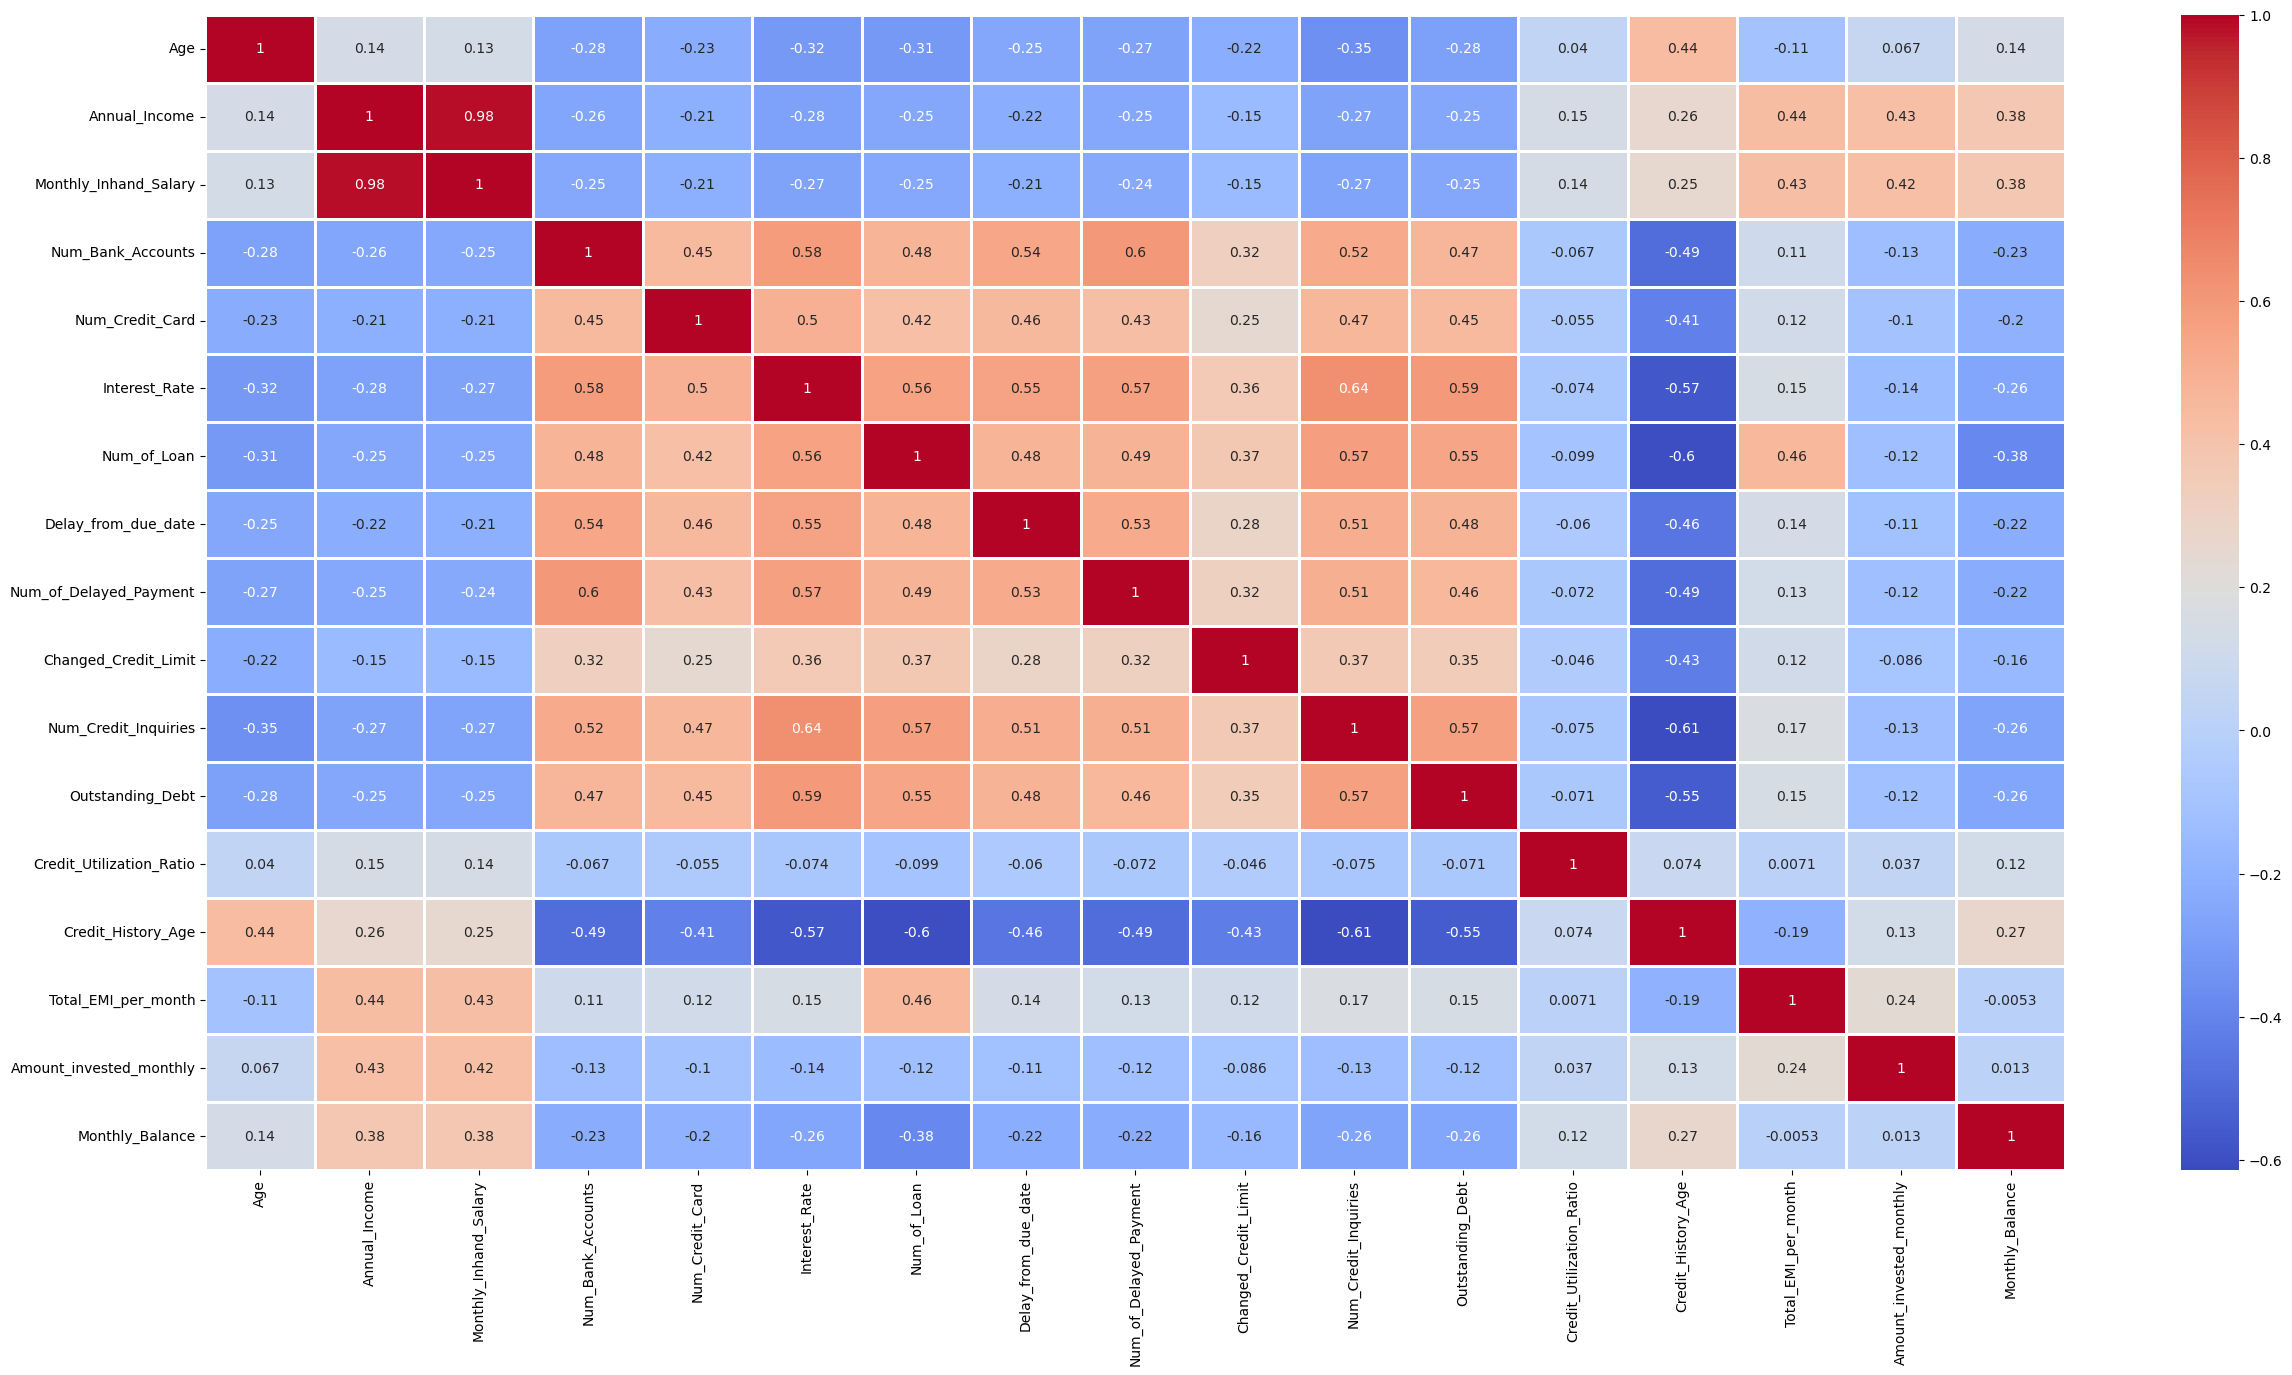

In [178]:
# Анализ корреляции числовых признаков
sns.heatmap(df_train[numeric_features].corr(), cmap = 'coolwarm', annot = True, linewidths = 1.0)
plt.gcf().set_size_inches(30,15)

Видим, что корреляция между Annual_Income и Monthly_Inhand_Salary = 1, исключим тогда признак Annual_Income.

In [179]:
df_train = df_train.drop('Annual_Income', axis = 1)
df_test = df_test.drop('Annual_Income', axis = 1)
numeric_features.remove('Annual_Income')

### Target: 'Credit_Score'. Анализ сбалансированности классов

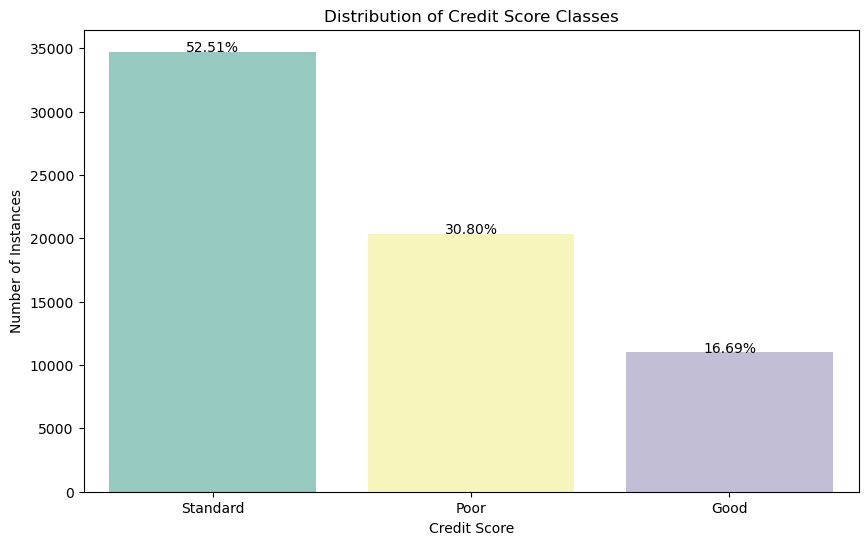

In [180]:
info_classes = get_value_count(df_train, 'Credit_Score')
plt.figure(figsize=(10, 6))
sns.barplot(x=info_classes['Credit_Score'], y=info_classes['counts'], palette='Set3')

for index, value in info_classes.iterrows():
    plt.text(index, value['counts'] + 0.5, value['percent'], ha='center')

plt.title('Distribution of Credit Score Classes')
plt.xlabel('Credit Score')
plt.ylabel('Number of Instances')

plt.show()

Это распределение показывает, что большинство клиентов имеют стандартный кредитный рейтинг, в этом наборе данных меньше клиентов с хорошим кредитным рейтингом.
Таким образом имеем несбалансированное распределение данных.
Этот дисбаланс может привести к тому, что модель будет слишком сильно фокусироваться на классе большинства и делать менее точные прогнозы для классов меньшинства.

In [181]:
# Кодировка классов
df_train['Credit_Score'].replace({"Poor": 0, "Standard": 1, "Good": 2}, inplace=True)
df_test['Credit_Score'].replace({"Poor": 0, "Standard": 1, "Good": 2}, inplace=True)

In [182]:
# Сохранение обработанных данных
df_train.to_csv('clean_data_train.csv', index=False)
df_test.to_csv('clean_data_test.csv', index=False)

# Data Preprocessing

In [187]:
X_train=X_train.drop('index',axis=1)
X_test=X_test.drop('index',axis=1)

In [183]:
X_train = df_train.drop(columns ="Credit_Score")
y_train = df_train["Credit_Score"]

X_test = df_test.drop(columns ="Credit_Score")
y_test = df_test["Credit_Score"]

### Нормализация данных в обучающей выборке

In [184]:
scaler = MinMaxScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

X_train.head()

,index,Age,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit-Builder Loan,Payday Loan,Debt Consolidation Loan,Mortgage Loan,Home Equity Loan,Auto Loan,Personal Loan,Amount_Spent,Payment_Value,Occupation_Writer
0,0,0.619048,0.086628,0.636364,0.727273,0.545455,0.555556,0.727273,0.571429,0.268217,...,1,1,0,0,1,0,0,1.000000,2.000000,0.0
1,1,0.309524,0.783729,0.636364,0.272727,0.181818,0.222222,0.563636,0.607143,0.561939,...,0,1,0,0,0,0,0,0.000000,2.000000,0.0
2,2,0.666667,0.392791,0.636364,0.727273,0.727273,0.555556,0.527273,0.821429,0.776345,...,0,0,1,0,0,0,0,1.000000,1.000000,0.0
3,3,0.928571,0.092695,0.636364,0.363636,0.151515,0.222222,0.127273,0.250000,0.481783,...,0,1,0,1,1,1,0,0.460841,0.863887,0.0
4,4,0.119048,0.776448,0.000000,0.363636,0.333333,0.111111,0.490909,0.392857,0.331839,...,0,0,0,0,0,0,0,0.000000,1.000000,0.0


### SMOTE для несбалансированных данных

Для обучающего набора применим алгоритм SMOTE (Synthetic Minority Over-sampling Technique) — это метод, используемый для устранения классового дисбаланса путем создания синтетических примеров для класса меньшинства.

In [189]:
y_train.value_counts()

Credit_Score
1    34728
0    20373
2    11035
Name: count, dtype: int64

In [190]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("X_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("X_train_smote shape :", X_train_smote.shape)
print("y_train_smote shape :", y_train_smote.shape)

y_train_smote.value_counts()

X_train shape : (66136, 43)
y_train shape : (66136,)
X_train_smote shape : (104184, 43)
y_train_smote shape : (104184,)


Credit_Score
1    34728
0    34728
2    34728
Name: count, dtype: int64

# Обучение

In [ ]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    '''
    Функция для оценки характеристик модели с использованием
    классификации Confusion_matrix() 

    '''

    def plottingConfusionMatrix(y, y_pred):
        plt.figure(figsize=(10,7))
        sns.heatmap(confusion_matrix(y, y_pred),
                    annot=True, cmap='vlag', fmt='.0f',
                    xticklabels=model.classes_,
                    yticklabels=model.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.tight_layout()
        plt.show()

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Test Set:")
    plottingConfusionMatrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    plottingConfusionMatrix(y_train, y_train_pred)
    print(classification_report(y_train, y_train_pred))

## KNN model

In [ ]:
num_neighbors = list(range(2, 26))

kNN_train_mistake = list()
kNN_test_mistake = list()

kNN_best_prediction = []
kNN_best_error = 1
best_k = 0

for k in num_neighbors:
    kNN_model = KNeighborsClassifier(n_neighbors = k, p = 1)
    kNN_model.fit(X_train_smote, y_train_smote)

    y_train_prediction = kNN_model.predict(X_train_smote)
    y_test_prediction = kNN_model.predict(X_test)

    kNN_train_mistake.append(np.mean(y_train_smote != y_train_prediction))
    kNN_test_mistake.append(np.mean(y_test != y_test_prediction))
    
    if (np.mean(y_test != y_test_prediction) < kNN_best_error):
        best_k = k
        kNN_best_prediction = y_test_prediction
        kNN_best_error = np.mean(y_test != y_test_prediction)

In [195]:
print(f'Лучшее значение ошибки на train: {min(kNN_train_mistake).round(4)}')
print(f'Лучшее значение ошибки на test: {min(kNN_test_mistake).round(4)}, при k = {best_k}')

Лучшее значение ошибки на train: 0.0923
Лучшее значение ошибки на test: 0.5871, при k = 3


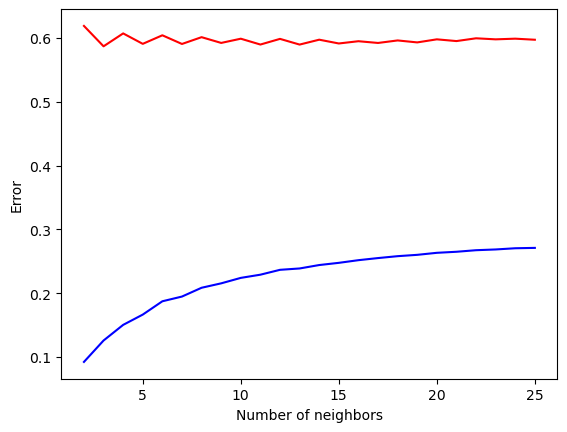

In [197]:
plt.plot(num_neighbors, kNN_train_mistake, color = 'blue', label = 'Train Error')
plt.plot(num_neighbors, kNN_test_mistake, color='red', label = 'Test Error')

plt.xlabel('Number of neighbors')
plt.ylabel('Error')
plt.show()

In [ ]:
kNN_model_best = KNeighborsClassifier(n_neighbors = 3, p = 1)
kNN_model_best.fit(X_train_smote, y_train_smote)

Test Set:


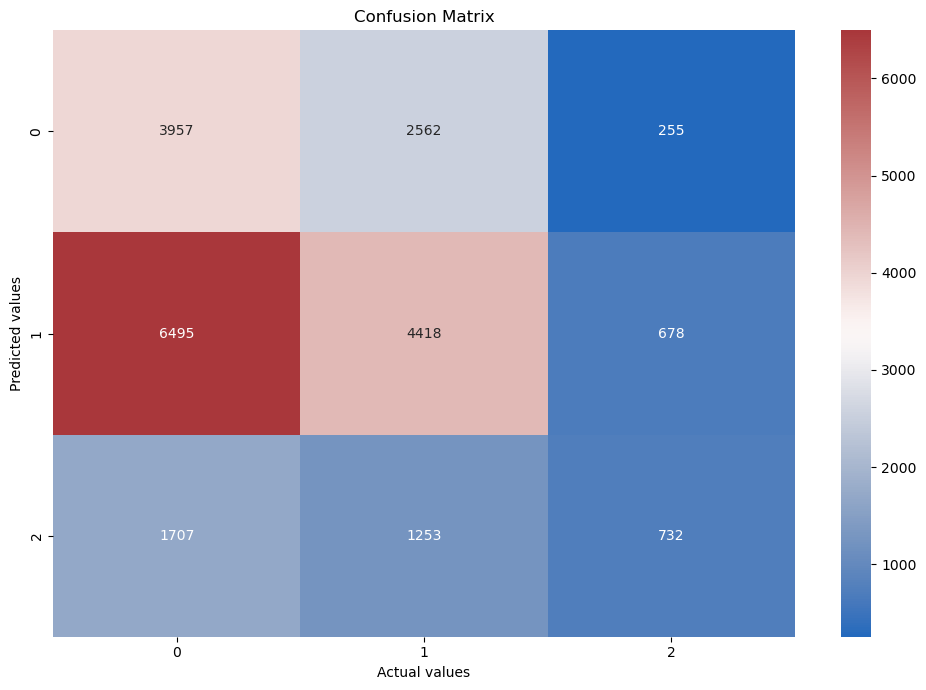

              precision    recall  f1-score   support

           0       0.33      0.58      0.42      6774
           1       0.54      0.38      0.45     11591
           2       0.44      0.20      0.27      3692

    accuracy                           0.41     22057
   macro avg       0.43      0.39      0.38     22057
weighted avg       0.46      0.41      0.41     22057


Train Set:


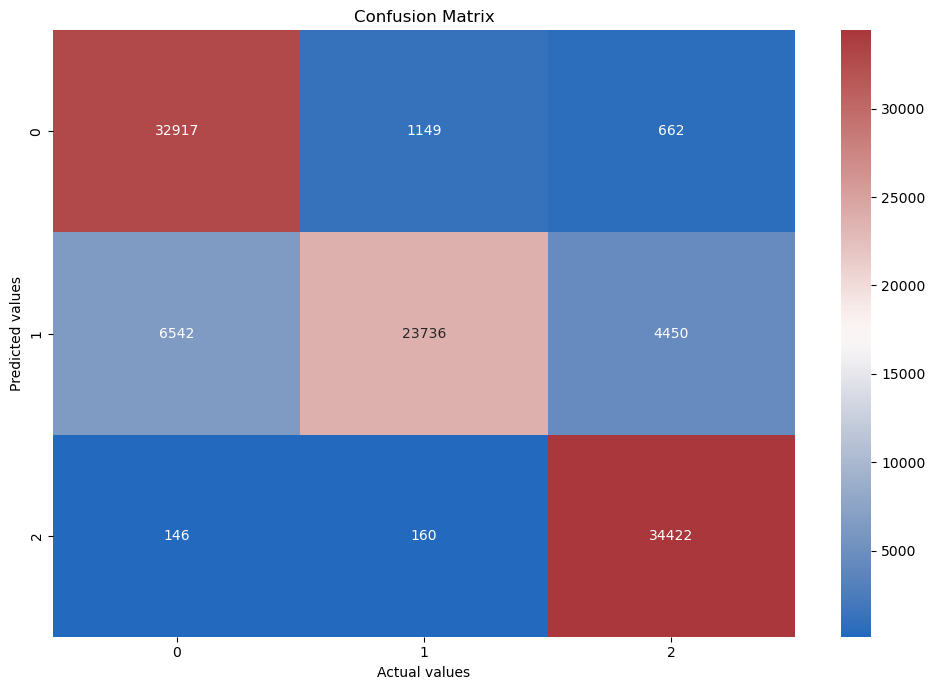

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     34728
           1       0.95      0.68      0.79     34728
           2       0.87      0.99      0.93     34728

    accuracy                           0.87    104184
   macro avg       0.88      0.87      0.87    104184
weighted avg       0.88      0.87      0.87    104184



In [216]:
eval_metric(kNN_model_best, X_train_smote, y_train_smote, X_test, y_test)

In [201]:
rfc_param = {"n_estimators": [5, 10, 15, 20, 25, 30, 35], 
            "max_depth": [5, 10, 15, 20, 25, 30, 35], 
            "min_samples_leaf": [1, 2, 3, 4, 5, 6 , 7]} 
rfc = RandomForestClassifier()             
rfc_grid = GridSearchCV(rfc, param_grid = rfc_param, cv = 5) 
rfc_grid.fit(X_train_smote, y_train_smote)
best_rfc_err = 1 - rfc_grid.best_score_ 
best_rfc_param = rfc_grid.best_params_ 
print("Error: {:.2f}%, parameters: {} ".format(100 * best_rfc_err, best_rfc_param))

Error: 17.85%, parameters: {'max_depth': 35, 'min_samples_leaf': 1, 'n_estimators': 35} 


Test Set:


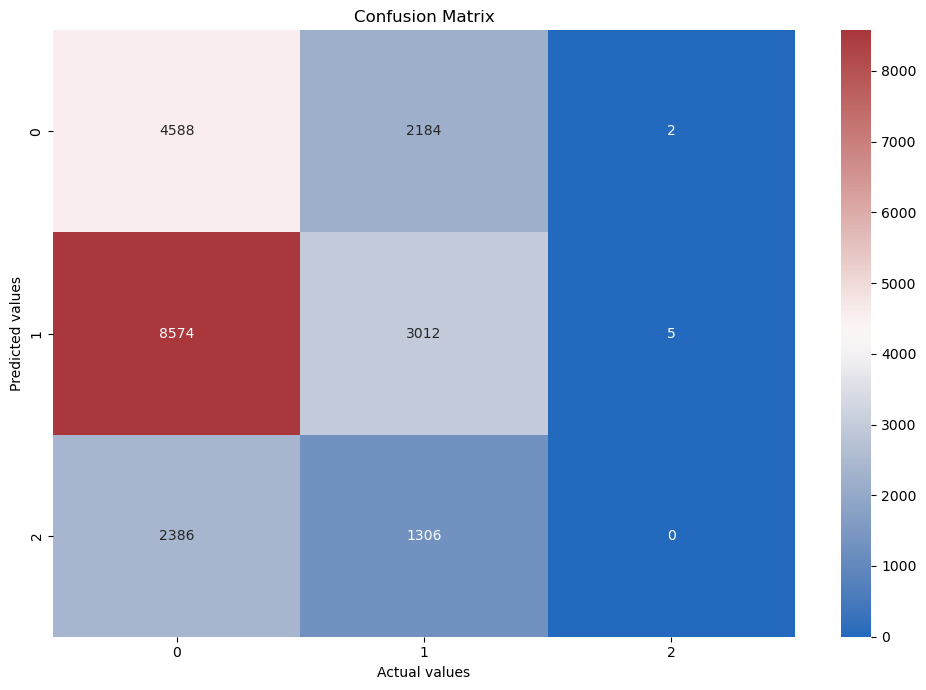

              precision    recall  f1-score   support

           0       0.30      0.68      0.41      6774
           1       0.46      0.26      0.33     11591
           2       0.00      0.00      0.00      3692

    accuracy                           0.34     22057
   macro avg       0.25      0.31      0.25     22057
weighted avg       0.33      0.34      0.30     22057


Train Set:


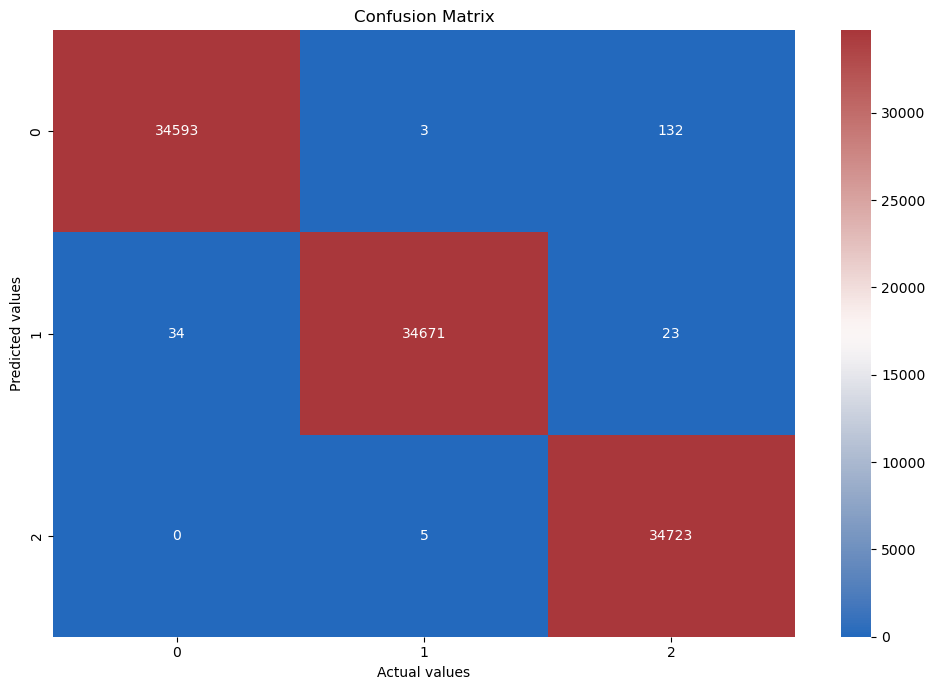

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34728
           1       1.00      1.00      1.00     34728
           2       1.00      1.00      1.00     34728

    accuracy                           1.00    104184
   macro avg       1.00      1.00      1.00    104184
weighted avg       1.00      1.00      1.00    104184



In [217]:
rfc_model_best = RandomForestClassifier(max_depth=35, min_samples_leaf=1, n_estimators=35)
rfc_model_best.fit(X_train_smote, y_train_smote)
eval_metric(rfc_model_best, X_train_smote, y_train_smote, X_test, y_test)

По результатам обучения очевидно, что модели переобучены, когда точность на обучающих выборках достигается достаточно высокая, а на тестовой она сильно падает. Но это можно объяснить тем, что в данных сильно несбалансированы классы. Если на обучающей мы смогли достичь баланса, добавив синтетических данных, то с данными в тестовой выборке явно есть проблемы с перевесом одного класса, а именно Standard. Это даже отражено в матрице ошибок, где преимущественный выбор класса отдается именно ему.